In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten, GRU
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [4]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [5]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [6]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.8)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [7]:
def mean_squared_error(X, lenght = 5):
    squared_error = 0
    for i in range(0, X.shape[0] - lenght):
        x = X[i:i+lenght]
        mean = x.mean()
        std = x.std()
        x = (x - mean)/std
        y = (X[i+lenght] - mean)/std
        squared_error += np.square(x[-1]-y)
    return squared_error/X.shape[0]

In [8]:
# For generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [9]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [11]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    gru_1 = GRU(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal')(inputs)
    batch_norm1 = tf.keras.layers.BatchNormalization()(gru_1)
    gru_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    gru_1_dropout = Dropout(0.3)(gru_1_LRelu)
    gru_2 = GRU(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal')(gru_1_dropout)
    batch_norm2 = tf.keras.layers.BatchNormalization()(gru_2)
    gru_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    gru_2_dropout = Dropout(0.3)(gru_2_LRelu)
    output_dense = Dense(n_features, activation=None)(gru_2_dropout)
    output = LeakyReLU(alpha=0.3)(output_dense) 

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model

## Discriminator

In [12]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [13]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [14]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

## Visualization

In [15]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [16]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [17]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [18]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [19]:
stock_code = "TSLA"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2010-07-07    1.093333    1.108667    0.998667    1.053333    1.053333   
6    2010-07-08    1.076000    1.168000    1.038000    1.164000    1.164000   
7    2010-07-09    1.172000    1.193333    1.103333    1.160000    1.160000   
8    2010-07-12    1.196667    1.204667    1.133333    1.136667    1.136667   
9    2010-07-13    1.159333    1.242667    1.126667    1.209333    1.209333   
...         ...         ...         ...         ...         ...         ...   
2641 2020-12-23  210.733337  217.166672  207.523331  215.326660  215.326660   
2642 2020-12-24  214.330002  222.029999  213.666672  220.589996  220.589996   
2643 2020-12-28  224.836670  227.133331  220.266663  221.229996  221.229996   
2644 2020-12-29  220.333328  223.300003  218.333328  221.996674  221.996674   
2645 2020-12-30  224.000000  232.199997  222.786667  231.593338  231.593338   

         Volume          Ma  
5     103825500    1.399867  
6     115671000    1.292000  
7      60759000    1.207067  
8      33037500    1.146267  
9      40201500    1.117600  
...         ...         ...  
2641   99519000  217.591333  
2642   68596800  219.138666  
2643   96835800  219.529999  
2644   68732400  217.442664  
2645  128538000  218.517999  

[2641 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru (GRU)                   (None, 5, 10)             570       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                             

Time for epoch 53 is 0.42637205123901367 sec Generator Loss: 1.2885856628417969,  Discriminator_loss: 0.9812910556793213
Time for epoch 54 is 0.42836856842041016 sec Generator Loss: 1.2836272716522217,  Discriminator_loss: 0.982546865940094
Time for epoch 55 is 0.4391205310821533 sec Generator Loss: 1.2865406274795532,  Discriminator_loss: 1.0001449584960938
Time for epoch 56 is 0.43085408210754395 sec Generator Loss: 1.2770596742630005,  Discriminator_loss: 1.0038281679153442
Time for epoch 57 is 0.4464225769042969 sec Generator Loss: 1.2949740886688232,  Discriminator_loss: 0.9724367260932922
Time for epoch 58 is 0.4563262462615967 sec Generator Loss: 1.311051368713379,  Discriminator_loss: 0.9771395921707153
Time for epoch 59 is 0.4839510917663574 sec Generator Loss: 1.2619527578353882,  Discriminator_loss: 0.9994631409645081
Time for epoch 60 is 0.42966628074645996 sec Generator Loss: 1.2518372535705566,  Discriminator_loss: 0.9956713914871216
Time for epoch 61 is 0.464108467102050

Time for epoch 122 is 0.4650416374206543 sec Generator Loss: 1.052403211593628,  Discriminator_loss: 1.1581034660339355
Time for epoch 123 is 0.43179965019226074 sec Generator Loss: 1.067387342453003,  Discriminator_loss: 1.152673363685608
Time for epoch 124 is 0.4334995746612549 sec Generator Loss: 1.0420628786087036,  Discriminator_loss: 1.1636861562728882
Time for epoch 125 is 0.4499168395996094 sec Generator Loss: 1.0391979217529297,  Discriminator_loss: 1.1686657667160034
Time for epoch 126 is 0.4598550796508789 sec Generator Loss: 1.0281256437301636,  Discriminator_loss: 1.17833411693573
Time for epoch 127 is 0.4818544387817383 sec Generator Loss: 1.0366042852401733,  Discriminator_loss: 1.1623115539550781
Time for epoch 128 is 0.43464088439941406 sec Generator Loss: 1.0431097745895386,  Discriminator_loss: 1.1780407428741455
Time for epoch 129 is 0.42371678352355957 sec Generator Loss: 1.0313177108764648,  Discriminator_loss: 1.1859339475631714
Time for epoch 130 is 0.4257206916

Time for epoch 190 is 0.48415231704711914 sec Generator Loss: 0.8955456018447876,  Discriminator_loss: 1.2898434400558472
Time for epoch 191 is 0.4637126922607422 sec Generator Loss: 0.8914719820022583,  Discriminator_loss: 1.2832865715026855
Time for epoch 192 is 0.45118093490600586 sec Generator Loss: 0.9060823321342468,  Discriminator_loss: 1.2842274904251099
Time for epoch 193 is 0.4356095790863037 sec Generator Loss: 0.8866392970085144,  Discriminator_loss: 1.2929426431655884
Time for epoch 194 is 0.44905543327331543 sec Generator Loss: 0.8834460377693176,  Discriminator_loss: 1.295777440071106
Time for epoch 195 is 0.4380528926849365 sec Generator Loss: 0.8954823613166809,  Discriminator_loss: 1.2929338216781616
Time for epoch 196 is 0.576171875 sec Generator Loss: 0.8862282037734985,  Discriminator_loss: 1.2924925088882446
Time for epoch 197 is 0.4951326847076416 sec Generator Loss: 0.890766978263855,  Discriminator_loss: 1.2980890274047852
Time for epoch 198 is 0.44464731216430

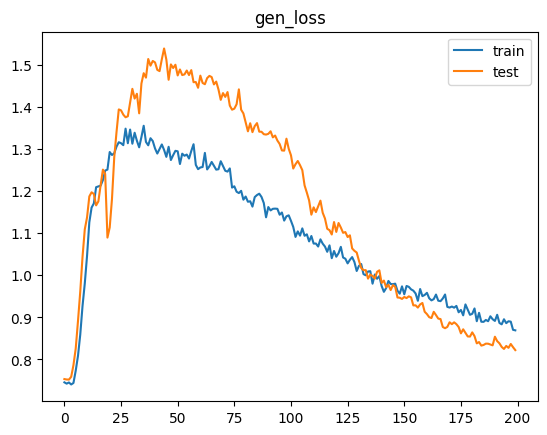

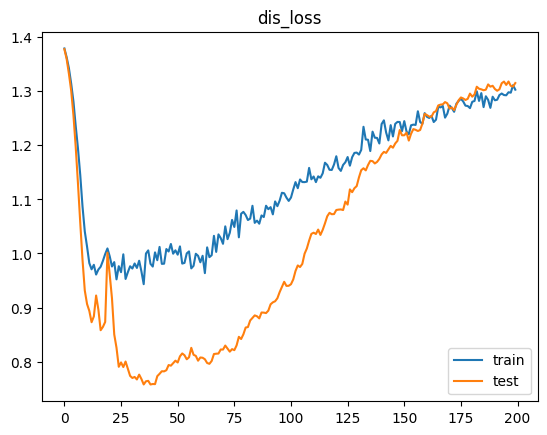

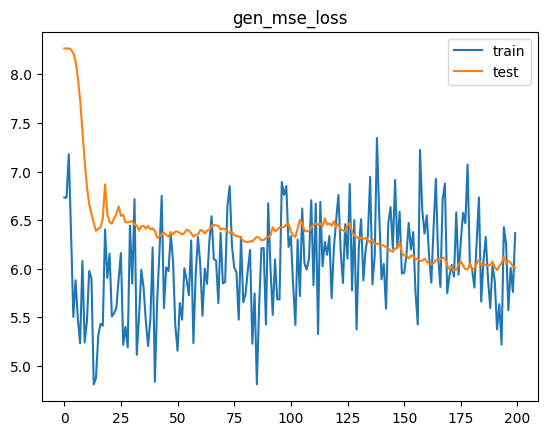

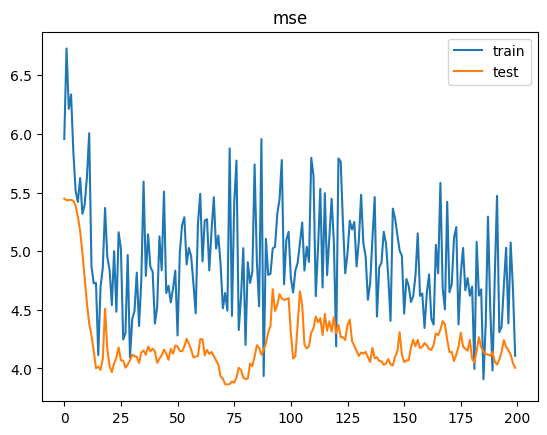

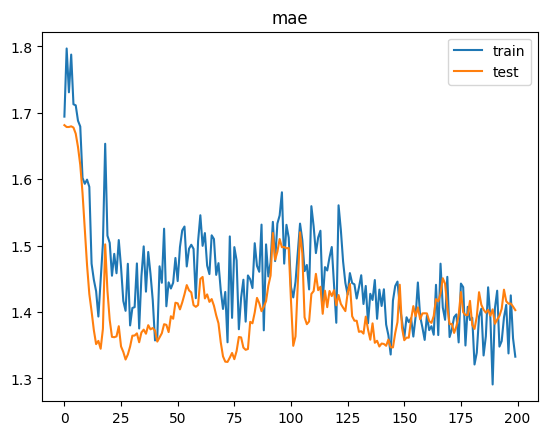

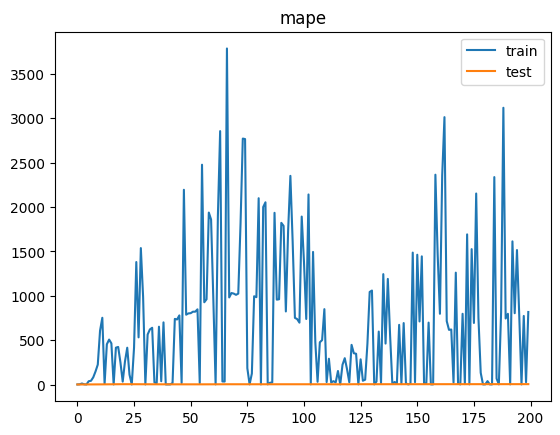

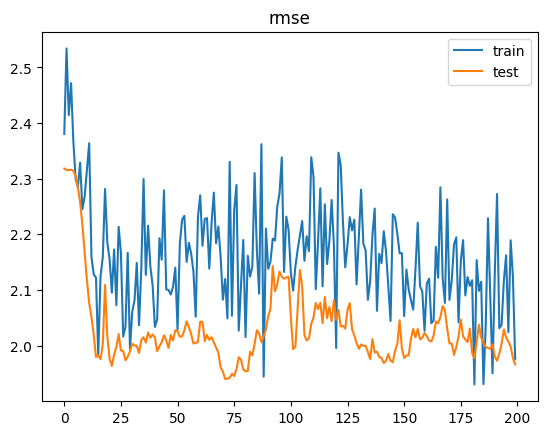

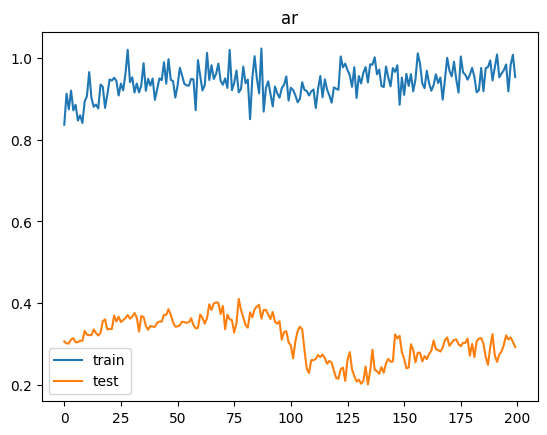

2/2 [==============================] - 0s 3ms/step


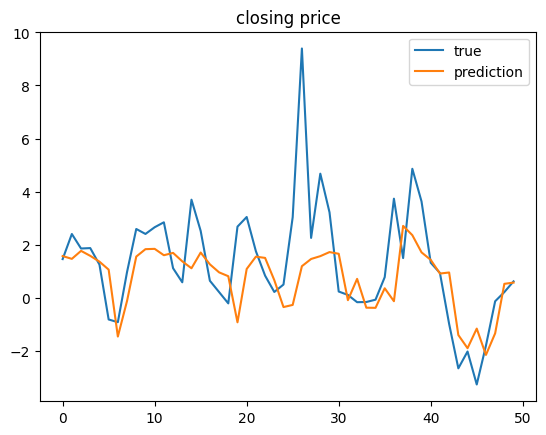

[MSE Baseline] train: 3.9461013332520447  test: 3.868181586758766
Delta time with epochs = 200: 0:01:39.656172
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_2 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 gru_3 (GRU)  

Time for epoch 52 is 0.453826904296875 sec Generator Loss: 1.1166681051254272,  Discriminator_loss: 1.1054123640060425
Time for epoch 53 is 0.4556455612182617 sec Generator Loss: 1.0783895254135132,  Discriminator_loss: 1.1486953496932983
Time for epoch 54 is 0.45803141593933105 sec Generator Loss: 1.1037416458129883,  Discriminator_loss: 1.1192426681518555
Time for epoch 55 is 0.4719078540802002 sec Generator Loss: 1.0900704860687256,  Discriminator_loss: 1.1178827285766602
Time for epoch 56 is 0.4499237537384033 sec Generator Loss: 1.0741770267486572,  Discriminator_loss: 1.135162353515625
Time for epoch 57 is 0.429027795791626 sec Generator Loss: 1.0657137632369995,  Discriminator_loss: 1.1420443058013916
Time for epoch 58 is 0.4285306930541992 sec Generator Loss: 1.0794392824172974,  Discriminator_loss: 1.123237133026123
Time for epoch 59 is 0.4277951717376709 sec Generator Loss: 1.0985442399978638,  Discriminator_loss: 1.136493444442749
Time for epoch 60 is 0.428011417388916 sec G

Time for epoch 121 is 0.42708873748779297 sec Generator Loss: 0.8796455264091492,  Discriminator_loss: 1.2922794818878174
Time for epoch 122 is 0.43436336517333984 sec Generator Loss: 0.8787121176719666,  Discriminator_loss: 1.2996103763580322
Time for epoch 123 is 0.45113325119018555 sec Generator Loss: 0.8874402046203613,  Discriminator_loss: 1.3067439794540405
Time for epoch 124 is 0.4473989009857178 sec Generator Loss: 0.8788869380950928,  Discriminator_loss: 1.310448169708252
Time for epoch 125 is 0.432232141494751 sec Generator Loss: 0.8782488107681274,  Discriminator_loss: 1.305176854133606
Time for epoch 126 is 0.43283581733703613 sec Generator Loss: 0.880894660949707,  Discriminator_loss: 1.2991756200790405
Time for epoch 127 is 0.42826271057128906 sec Generator Loss: 0.8840066194534302,  Discriminator_loss: 1.300690770149231
Time for epoch 128 is 0.43451833724975586 sec Generator Loss: 0.8703972697257996,  Discriminator_loss: 1.2991788387298584
Time for epoch 129 is 0.4629611

Time for epoch 189 is 0.47095680236816406 sec Generator Loss: 0.8920149803161621,  Discriminator_loss: 1.2903549671173096
Time for epoch 190 is 0.46758246421813965 sec Generator Loss: 0.8876092433929443,  Discriminator_loss: 1.291930079460144
Time for epoch 191 is 0.46877121925354004 sec Generator Loss: 0.8709606528282166,  Discriminator_loss: 1.298294186592102
Time for epoch 192 is 0.46853041648864746 sec Generator Loss: 0.8847343921661377,  Discriminator_loss: 1.296487808227539
Time for epoch 193 is 0.46632933616638184 sec Generator Loss: 0.8781669735908508,  Discriminator_loss: 1.3024417161941528
Time for epoch 194 is 0.4654109477996826 sec Generator Loss: 0.8847041130065918,  Discriminator_loss: 1.287851333618164
Time for epoch 195 is 0.4716794490814209 sec Generator Loss: 0.87693190574646,  Discriminator_loss: 1.3007838726043701
Time for epoch 196 is 0.47269105911254883 sec Generator Loss: 0.8973613381385803,  Discriminator_loss: 1.2835791110992432
Time for epoch 197 is 0.47256731

Time for epoch 257 is 0.4613969326019287 sec Generator Loss: 0.8590741753578186,  Discriminator_loss: 1.3096486330032349
Time for epoch 258 is 0.5032219886779785 sec Generator Loss: 0.8866945505142212,  Discriminator_loss: 1.3039791584014893
Time for epoch 259 is 0.4692513942718506 sec Generator Loss: 0.8716886639595032,  Discriminator_loss: 1.2977890968322754
Time for epoch 260 is 0.4742758274078369 sec Generator Loss: 0.8724241256713867,  Discriminator_loss: 1.2894941568374634
Time for epoch 261 is 0.47177982330322266 sec Generator Loss: 0.8808456659317017,  Discriminator_loss: 1.3042811155319214
Time for epoch 262 is 0.47096824645996094 sec Generator Loss: 0.8654086589813232,  Discriminator_loss: 1.2951215505599976
Time for epoch 263 is 0.4660673141479492 sec Generator Loss: 0.8909671902656555,  Discriminator_loss: 1.2787493467330933
Time for epoch 264 is 0.47023963928222656 sec Generator Loss: 0.8786402344703674,  Discriminator_loss: 1.3006864786148071
Time for epoch 265 is 0.47258

Time for epoch 325 is 0.4660825729370117 sec Generator Loss: 0.8678280711174011,  Discriminator_loss: 1.300385594367981
Time for epoch 326 is 0.4665088653564453 sec Generator Loss: 0.8809884190559387,  Discriminator_loss: 1.2961211204528809
Time for epoch 327 is 0.46361660957336426 sec Generator Loss: 0.8635095953941345,  Discriminator_loss: 1.3074408769607544
Time for epoch 328 is 0.470242977142334 sec Generator Loss: 0.8772861957550049,  Discriminator_loss: 1.2971272468566895
Time for epoch 329 is 0.46628522872924805 sec Generator Loss: 0.8611512780189514,  Discriminator_loss: 1.3099992275238037
Time for epoch 330 is 0.4716799259185791 sec Generator Loss: 0.8725608587265015,  Discriminator_loss: 1.292256236076355
Time for epoch 331 is 0.4675273895263672 sec Generator Loss: 0.8863351345062256,  Discriminator_loss: 1.2912603616714478
Time for epoch 332 is 0.472597599029541 sec Generator Loss: 0.8624311089515686,  Discriminator_loss: 1.314687967300415
Time for epoch 333 is 0.47398138046

Time for epoch 393 is 0.5154604911804199 sec Generator Loss: 0.8849252462387085,  Discriminator_loss: 1.295566201210022
Time for epoch 394 is 0.5129339694976807 sec Generator Loss: 0.8827951550483704,  Discriminator_loss: 1.302167534828186
Time for epoch 395 is 0.5174925327301025 sec Generator Loss: 0.8718346953392029,  Discriminator_loss: 1.2935419082641602
Time for epoch 396 is 0.5357627868652344 sec Generator Loss: 0.8754109144210815,  Discriminator_loss: 1.284818172454834
Time for epoch 397 is 0.5244016647338867 sec Generator Loss: 0.8725109696388245,  Discriminator_loss: 1.302862286567688
Time for epoch 398 is 0.5201880931854248 sec Generator Loss: 0.8644270896911621,  Discriminator_loss: 1.3212034702301025
Time for epoch 399 is 0.5001349449157715 sec Generator Loss: 0.8529502153396606,  Discriminator_loss: 1.3142527341842651
Time for epoch 400 is 0.51511549949646 sec Generator Loss: 0.858592689037323,  Discriminator_loss: 1.3050391674041748
Time for epoch 401 is 0.503458261489868

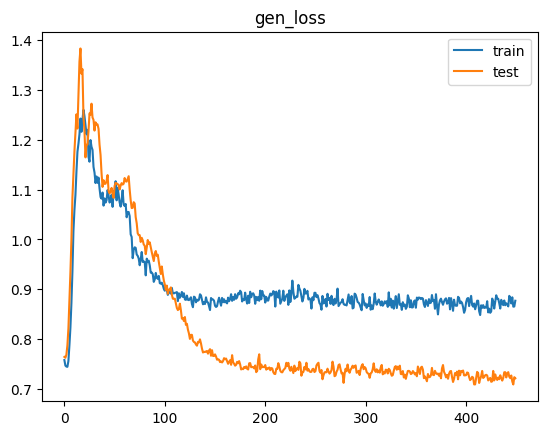

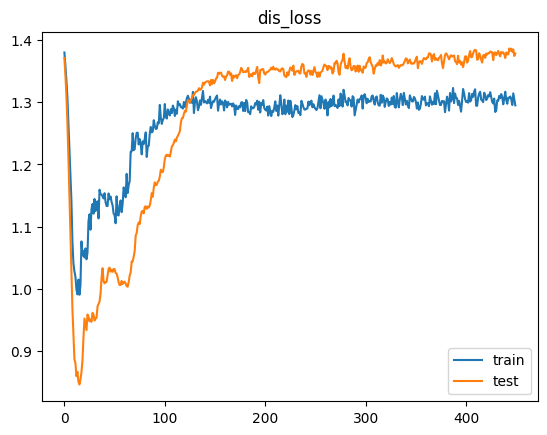

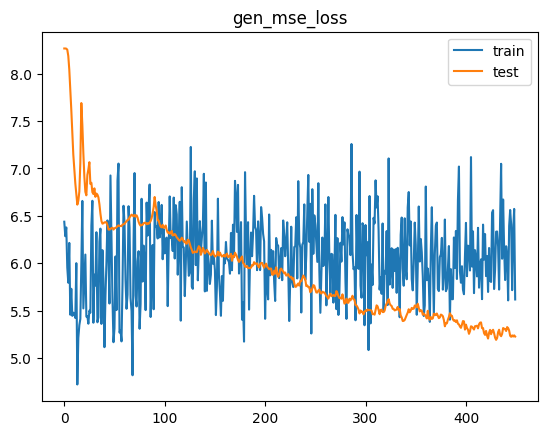

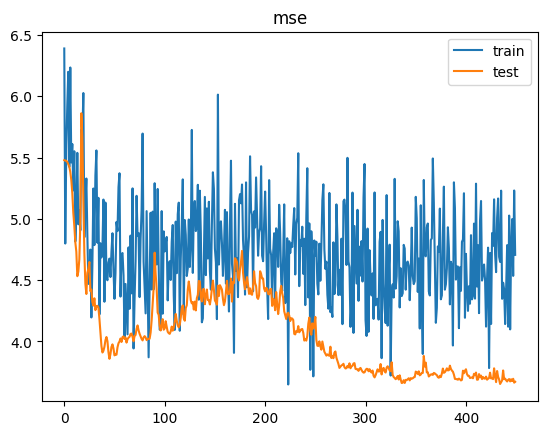

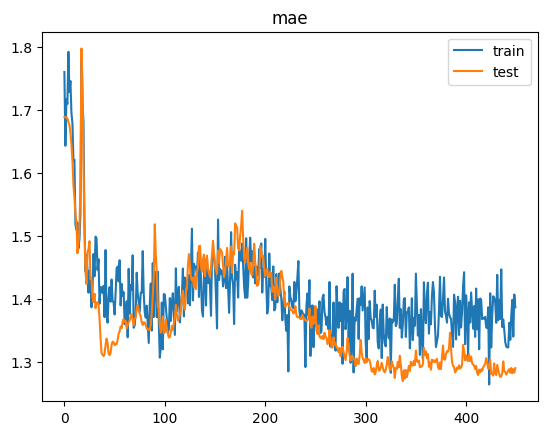

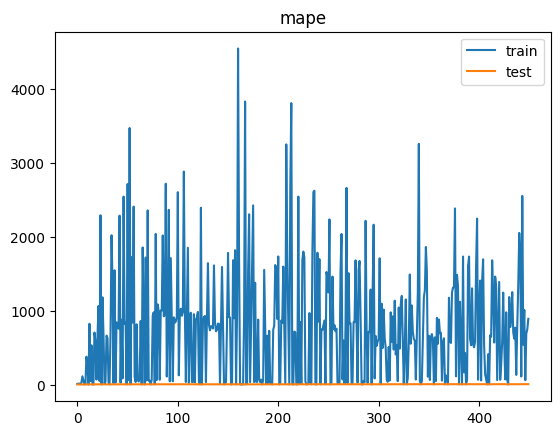

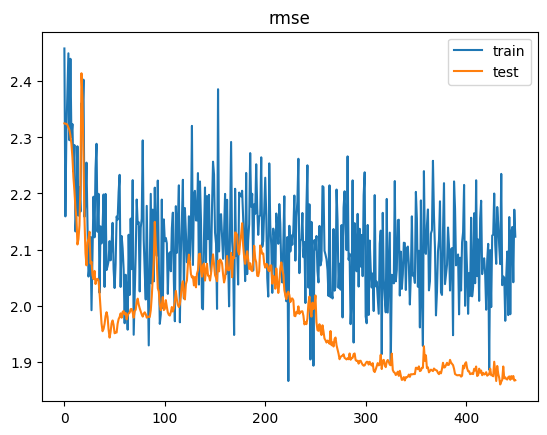

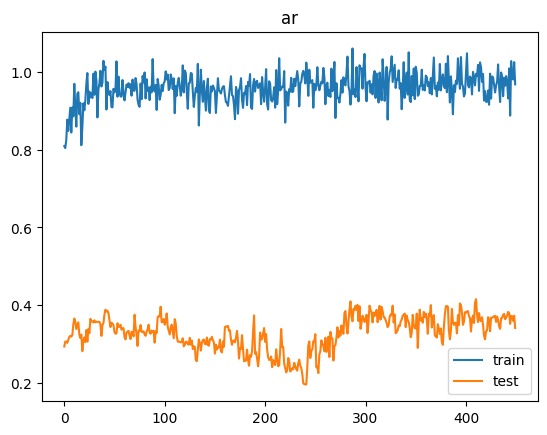

2/2 [==============================] - 0s 3ms/step


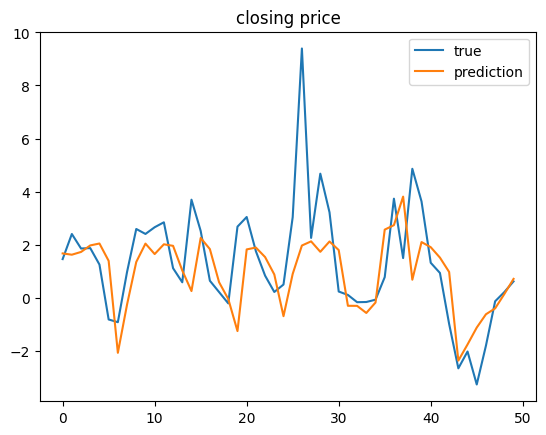

[MSE Baseline] train: 4.410428718924333  test: 3.868181586758766
Delta time with epochs = 450: 0:03:42.636816
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_4 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_5 (GRU)   

Time for epoch 52 is 0.4701218605041504 sec Generator Loss: 1.2206164598464966,  Discriminator_loss: 1.0466784238815308
Time for epoch 53 is 0.4695889949798584 sec Generator Loss: 1.206417441368103,  Discriminator_loss: 1.094497561454773
Time for epoch 54 is 0.4726743698120117 sec Generator Loss: 1.179443597793579,  Discriminator_loss: 1.0661896467208862
Time for epoch 55 is 0.47380709648132324 sec Generator Loss: 1.206886649131775,  Discriminator_loss: 1.06696617603302
Time for epoch 56 is 0.4706897735595703 sec Generator Loss: 1.1958281993865967,  Discriminator_loss: 1.0994800329208374
Time for epoch 57 is 0.47301745414733887 sec Generator Loss: 1.2032965421676636,  Discriminator_loss: 1.0897670984268188
Time for epoch 58 is 0.4697897434234619 sec Generator Loss: 1.1793018579483032,  Discriminator_loss: 1.0802028179168701
Time for epoch 59 is 0.4855482578277588 sec Generator Loss: 1.1776793003082275,  Discriminator_loss: 1.10049307346344
Time for epoch 60 is 0.47454047203063965 sec G

Time for epoch 121 is 0.47263097763061523 sec Generator Loss: 0.9419400095939636,  Discriminator_loss: 1.2577821016311646
Time for epoch 122 is 0.4703941345214844 sec Generator Loss: 0.9427486062049866,  Discriminator_loss: 1.2435027360916138
Time for epoch 123 is 0.4764237403869629 sec Generator Loss: 0.9427098035812378,  Discriminator_loss: 1.24543035030365
Time for epoch 124 is 0.46958494186401367 sec Generator Loss: 0.9420608282089233,  Discriminator_loss: 1.2452459335327148
Time for epoch 125 is 0.4729483127593994 sec Generator Loss: 0.9490523934364319,  Discriminator_loss: 1.2430438995361328
Time for epoch 126 is 0.46768712997436523 sec Generator Loss: 0.9371548891067505,  Discriminator_loss: 1.258321762084961
Time for epoch 127 is 0.46662354469299316 sec Generator Loss: 0.949131965637207,  Discriminator_loss: 1.2429543733596802
Time for epoch 128 is 0.47250795364379883 sec Generator Loss: 0.9260517954826355,  Discriminator_loss: 1.2702858448028564
Time for epoch 129 is 0.4841628

Time for epoch 189 is 0.4798550605773926 sec Generator Loss: 0.8806201219558716,  Discriminator_loss: 1.2899415493011475
Time for epoch 190 is 0.4720604419708252 sec Generator Loss: 0.8906475305557251,  Discriminator_loss: 1.290056824684143
Time for epoch 191 is 0.46961259841918945 sec Generator Loss: 0.8621718287467957,  Discriminator_loss: 1.3134472370147705
Time for epoch 192 is 0.46827125549316406 sec Generator Loss: 0.8829574584960938,  Discriminator_loss: 1.285861611366272
Time for epoch 193 is 0.46445631980895996 sec Generator Loss: 0.869118869304657,  Discriminator_loss: 1.2951279878616333
Time for epoch 194 is 0.46816110610961914 sec Generator Loss: 0.8830191493034363,  Discriminator_loss: 1.2848997116088867
Time for epoch 195 is 0.4698913097381592 sec Generator Loss: 0.8895469903945923,  Discriminator_loss: 1.2909709215164185
Time for epoch 196 is 0.47592926025390625 sec Generator Loss: 0.8760440945625305,  Discriminator_loss: 1.2991057634353638
Time for epoch 197 is 0.471420

Time for epoch 257 is 0.5590245723724365 sec Generator Loss: 0.8694390058517456,  Discriminator_loss: 1.3046188354492188
Time for epoch 258 is 0.5293755531311035 sec Generator Loss: 0.8520087003707886,  Discriminator_loss: 1.3159130811691284
Time for epoch 259 is 0.563894510269165 sec Generator Loss: 0.8756695985794067,  Discriminator_loss: 1.2995861768722534
Time for epoch 260 is 0.5673117637634277 sec Generator Loss: 0.8613460063934326,  Discriminator_loss: 1.3166041374206543
Time for epoch 261 is 0.5527136325836182 sec Generator Loss: 0.8709502220153809,  Discriminator_loss: 1.3021588325500488
Time for epoch 262 is 0.5756740570068359 sec Generator Loss: 0.8699029684066772,  Discriminator_loss: 1.301565170288086
Time for epoch 263 is 0.4720585346221924 sec Generator Loss: 0.8716800808906555,  Discriminator_loss: 1.3022891283035278
Time for epoch 264 is 0.4305863380432129 sec Generator Loss: 0.8648776412010193,  Discriminator_loss: 1.3007630109786987
Time for epoch 265 is 0.4347784519

Time for epoch 325 is 0.43345069885253906 sec Generator Loss: 0.8596928715705872,  Discriminator_loss: 1.3033124208450317
Time for epoch 326 is 0.43552064895629883 sec Generator Loss: 0.8556516170501709,  Discriminator_loss: 1.3218809366226196
Time for epoch 327 is 0.430983304977417 sec Generator Loss: 0.8559821248054504,  Discriminator_loss: 1.3087137937545776
Time for epoch 328 is 0.4235236644744873 sec Generator Loss: 0.8569658398628235,  Discriminator_loss: 1.3107763528823853
Time for epoch 329 is 0.42602968215942383 sec Generator Loss: 0.8633600473403931,  Discriminator_loss: 1.3059922456741333
Time for epoch 330 is 0.4300868511199951 sec Generator Loss: 0.8430339097976685,  Discriminator_loss: 1.3198167085647583
Time for epoch 331 is 0.42870259284973145 sec Generator Loss: 0.8619970679283142,  Discriminator_loss: 1.3028558492660522
Time for epoch 332 is 0.42910313606262207 sec Generator Loss: 0.8721989393234253,  Discriminator_loss: 1.2995548248291016
Time for epoch 333 is 0.4447

Time for epoch 393 is 0.5307083129882812 sec Generator Loss: 0.862145721912384,  Discriminator_loss: 1.3071116209030151
Time for epoch 394 is 0.49668169021606445 sec Generator Loss: 0.87254399061203,  Discriminator_loss: 1.3015434741973877
Time for epoch 395 is 0.483806848526001 sec Generator Loss: 0.8415323495864868,  Discriminator_loss: 1.319565773010254
Time for epoch 396 is 0.47269701957702637 sec Generator Loss: 0.8522169589996338,  Discriminator_loss: 1.309910535812378
Time for epoch 397 is 0.4835028648376465 sec Generator Loss: 0.865219235420227,  Discriminator_loss: 1.3001022338867188
Time for epoch 398 is 0.47763895988464355 sec Generator Loss: 0.8497394323348999,  Discriminator_loss: 1.3191211223602295
Time for epoch 399 is 0.4916706085205078 sec Generator Loss: 0.8581868410110474,  Discriminator_loss: 1.3139243125915527
Time for epoch 400 is 0.48149585723876953 sec Generator Loss: 0.8495771884918213,  Discriminator_loss: 1.3200021982192993
Time for epoch 401 is 0.48344087600

Time for epoch 461 is 0.5487077236175537 sec Generator Loss: 0.8577613830566406,  Discriminator_loss: 1.3086498975753784
Time for epoch 462 is 0.4876401424407959 sec Generator Loss: 0.8491420149803162,  Discriminator_loss: 1.3149957656860352
Time for epoch 463 is 0.46691155433654785 sec Generator Loss: 0.840996503829956,  Discriminator_loss: 1.3142833709716797
Time for epoch 464 is 0.47006654739379883 sec Generator Loss: 0.8475294709205627,  Discriminator_loss: 1.326434850692749
Time for epoch 465 is 0.495241641998291 sec Generator Loss: 0.8650577068328857,  Discriminator_loss: 1.3081002235412598
Time for epoch 466 is 0.4559328556060791 sec Generator Loss: 0.8677732944488525,  Discriminator_loss: 1.314107060432434
Time for epoch 467 is 0.44637036323547363 sec Generator Loss: 0.8391954898834229,  Discriminator_loss: 1.3075753450393677
Time for epoch 468 is 0.46593332290649414 sec Generator Loss: 0.868765115737915,  Discriminator_loss: 1.2993154525756836
Time for epoch 469 is 0.450065612

Time for epoch 529 is 0.4634268283843994 sec Generator Loss: 0.8598892092704773,  Discriminator_loss: 1.3017373085021973
Time for epoch 530 is 0.4510324001312256 sec Generator Loss: 0.8550595045089722,  Discriminator_loss: 1.3173736333847046
Time for epoch 531 is 0.45319080352783203 sec Generator Loss: 0.8454419374465942,  Discriminator_loss: 1.321813941001892
Time for epoch 532 is 0.4531748294830322 sec Generator Loss: 0.8396109342575073,  Discriminator_loss: 1.3213444948196411
Time for epoch 533 is 0.47034287452697754 sec Generator Loss: 0.8622875809669495,  Discriminator_loss: 1.3042423725128174
Time for epoch 534 is 0.4655416011810303 sec Generator Loss: 0.8775041699409485,  Discriminator_loss: 1.3122326135635376
Time for epoch 535 is 0.44971704483032227 sec Generator Loss: 0.8562135100364685,  Discriminator_loss: 1.3235745429992676
Time for epoch 536 is 0.4565763473510742 sec Generator Loss: 0.8517167568206787,  Discriminator_loss: 1.3148657083511353
Time for epoch 537 is 0.456618

Time for epoch 597 is 0.43744683265686035 sec Generator Loss: 0.848717451095581,  Discriminator_loss: 1.3193466663360596
Time for epoch 598 is 0.43079400062561035 sec Generator Loss: 0.8676437139511108,  Discriminator_loss: 1.3006114959716797
Time for epoch 599 is 0.43981409072875977 sec Generator Loss: 0.8639998435974121,  Discriminator_loss: 1.3036694526672363
Time for epoch 600 is 0.4335641860961914 sec Generator Loss: 0.850135087966919,  Discriminator_loss: 1.307071328163147
Time for epoch 601 is 0.4370143413543701 sec Generator Loss: 0.8533788919448853,  Discriminator_loss: 1.330430269241333
Time for epoch 602 is 0.43892431259155273 sec Generator Loss: 0.8537883758544922,  Discriminator_loss: 1.3139735460281372
Time for epoch 603 is 0.436481237411499 sec Generator Loss: 0.8576075434684753,  Discriminator_loss: 1.3009203672409058
Time for epoch 604 is 0.43099498748779297 sec Generator Loss: 0.8610043525695801,  Discriminator_loss: 1.3081830739974976
Time for epoch 605 is 0.42957401

Time for epoch 665 is 0.47452592849731445 sec Generator Loss: 0.8643372654914856,  Discriminator_loss: 1.3125765323638916
Time for epoch 666 is 0.4757955074310303 sec Generator Loss: 0.8696610331535339,  Discriminator_loss: 1.3064507246017456
Time for epoch 667 is 0.48333001136779785 sec Generator Loss: 0.848125696182251,  Discriminator_loss: 1.3171253204345703
Time for epoch 668 is 0.46968507766723633 sec Generator Loss: 0.8548812866210938,  Discriminator_loss: 1.308945894241333
Time for epoch 669 is 0.47576451301574707 sec Generator Loss: 0.8349704146385193,  Discriminator_loss: 1.3123360872268677
Time for epoch 670 is 0.4758265018463135 sec Generator Loss: 0.8500059843063354,  Discriminator_loss: 1.3087124824523926
Time for epoch 671 is 0.47302961349487305 sec Generator Loss: 0.8558616042137146,  Discriminator_loss: 1.3085850477218628
Time for epoch 672 is 0.4773857593536377 sec Generator Loss: 0.8635078072547913,  Discriminator_loss: 1.3141683340072632
Time for epoch 673 is 0.46857

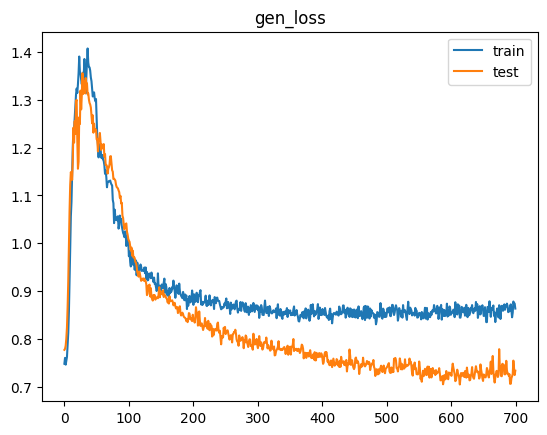

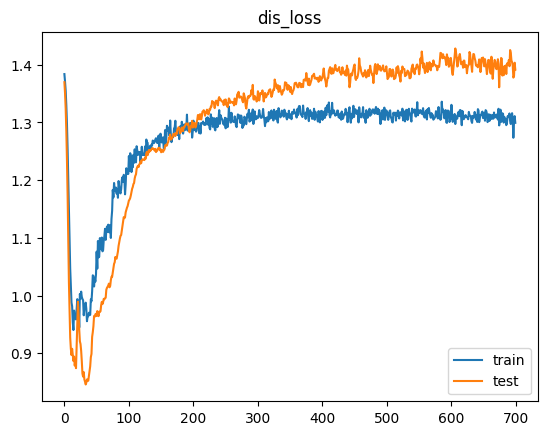

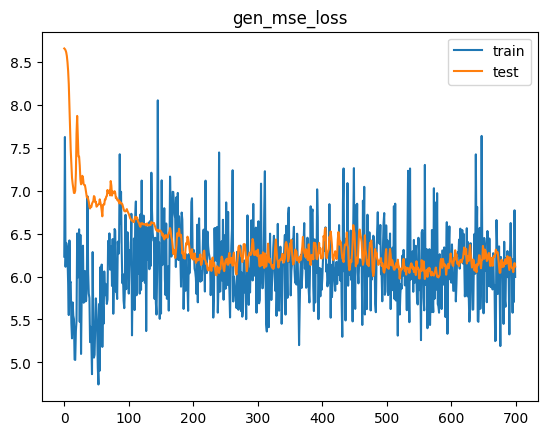

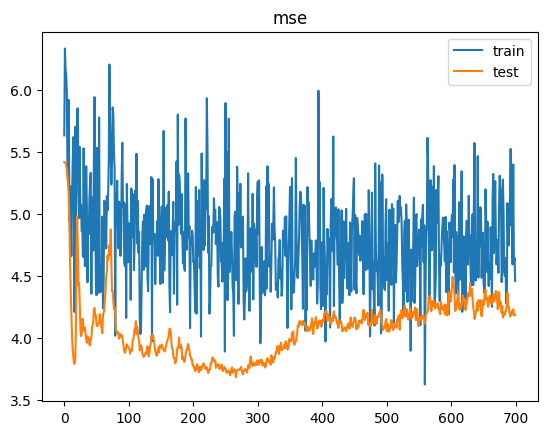

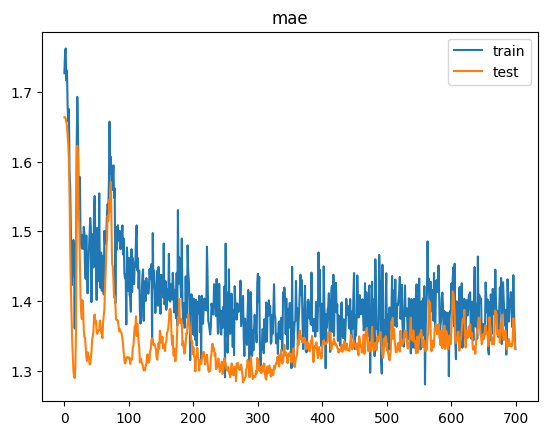

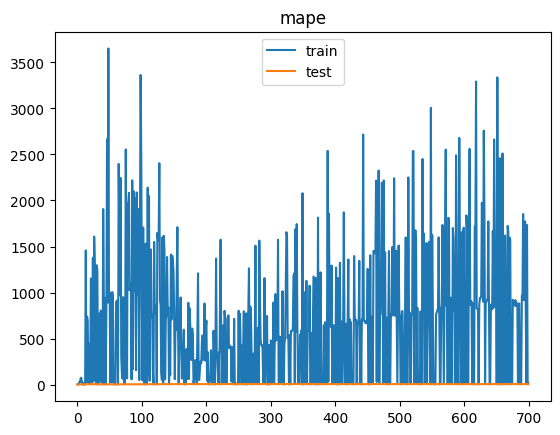

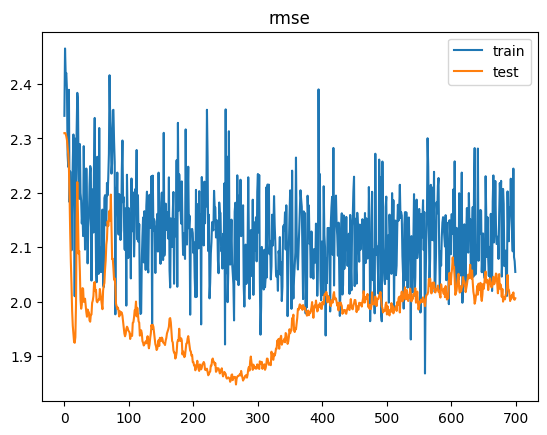

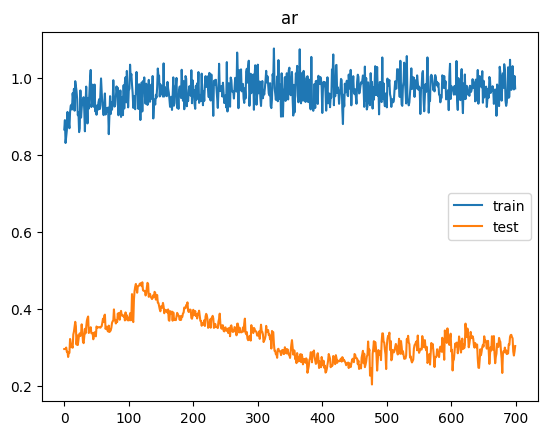

2/2 [==============================] - 0s 5ms/step


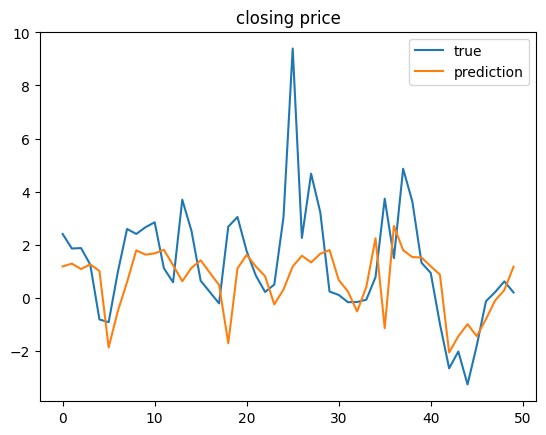

[MSE Baseline] train: 4.654884088978076  test: 3.7469059248471765
Delta time with epochs = 700: 0:05:41.977843


In [20]:
for epochs in [200, 450, 700]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("gru_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_6 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_7 (GRU)                 (None, 10)                660       
                                                           

Time for epoch 53 is 0.4814951419830322 sec Generator Loss: 1.1326467990875244,  Discriminator_loss: 1.1306580305099487
Time for epoch 54 is 0.48821592330932617 sec Generator Loss: 1.1421042680740356,  Discriminator_loss: 1.1488970518112183
Time for epoch 55 is 0.4724907875061035 sec Generator Loss: 1.1474171876907349,  Discriminator_loss: 1.1291090250015259
Time for epoch 56 is 0.47446155548095703 sec Generator Loss: 1.1356961727142334,  Discriminator_loss: 1.1614282131195068
Time for epoch 57 is 0.4807605743408203 sec Generator Loss: 1.1093028783798218,  Discriminator_loss: 1.157632827758789
Time for epoch 58 is 0.48172688484191895 sec Generator Loss: 1.1174981594085693,  Discriminator_loss: 1.1426429748535156
Time for epoch 59 is 0.48972320556640625 sec Generator Loss: 1.0876199007034302,  Discriminator_loss: 1.173702597618103
Time for epoch 60 is 0.4753081798553467 sec Generator Loss: 1.0918737649917603,  Discriminator_loss: 1.1589736938476562
Time for epoch 61 is 0.475971221923828

Time for epoch 122 is 0.5621964931488037 sec Generator Loss: 0.9139918088912964,  Discriminator_loss: 1.2736018896102905
Time for epoch 123 is 0.519885778427124 sec Generator Loss: 0.9300059080123901,  Discriminator_loss: 1.2750813961029053
Time for epoch 124 is 0.4350922107696533 sec Generator Loss: 0.9203516244888306,  Discriminator_loss: 1.269227147102356
Time for epoch 125 is 0.4915895462036133 sec Generator Loss: 0.9168550968170166,  Discriminator_loss: 1.266021728515625
Time for epoch 126 is 0.5344009399414062 sec Generator Loss: 0.9145789742469788,  Discriminator_loss: 1.276079535484314
Time for epoch 127 is 0.48138952255249023 sec Generator Loss: 0.9115992188453674,  Discriminator_loss: 1.285483956336975
Time for epoch 128 is 0.4639005661010742 sec Generator Loss: 0.9090532064437866,  Discriminator_loss: 1.2792209386825562
Time for epoch 129 is 0.4470689296722412 sec Generator Loss: 0.9279530048370361,  Discriminator_loss: 1.2595429420471191
Time for epoch 130 is 0.459940910339

Time for epoch 190 is 0.46393465995788574 sec Generator Loss: 0.887929379940033,  Discriminator_loss: 1.2904927730560303
Time for epoch 191 is 0.4782559871673584 sec Generator Loss: 0.8853632807731628,  Discriminator_loss: 1.2892266511917114
Time for epoch 192 is 0.4494915008544922 sec Generator Loss: 0.9037345051765442,  Discriminator_loss: 1.2884763479232788
Time for epoch 193 is 0.4465162754058838 sec Generator Loss: 0.9015814065933228,  Discriminator_loss: 1.2728077173233032
Time for epoch 194 is 0.4763057231903076 sec Generator Loss: 0.8935404419898987,  Discriminator_loss: 1.2900373935699463
Time for epoch 195 is 0.4485595226287842 sec Generator Loss: 0.8919143080711365,  Discriminator_loss: 1.2795531749725342
Time for epoch 196 is 0.4364969730377197 sec Generator Loss: 0.8779095411300659,  Discriminator_loss: 1.3065152168273926
Time for epoch 197 is 0.44742560386657715 sec Generator Loss: 0.8907736539840698,  Discriminator_loss: 1.2955113649368286
Time for epoch 198 is 0.4461922

Time for epoch 258 is 0.4778447151184082 sec Generator Loss: 0.8809342980384827,  Discriminator_loss: 1.2944623231887817
Time for epoch 259 is 0.47403454780578613 sec Generator Loss: 0.861382007598877,  Discriminator_loss: 1.3032352924346924
Time for epoch 260 is 0.47750186920166016 sec Generator Loss: 0.8831436038017273,  Discriminator_loss: 1.2876198291778564
Time for epoch 261 is 0.4759960174560547 sec Generator Loss: 0.8816804885864258,  Discriminator_loss: 1.3013502359390259
Time for epoch 262 is 0.4753701686859131 sec Generator Loss: 0.8783381581306458,  Discriminator_loss: 1.2921863794326782
Time for epoch 263 is 0.47989678382873535 sec Generator Loss: 0.8798649907112122,  Discriminator_loss: 1.2916004657745361
Time for epoch 264 is 0.4810640811920166 sec Generator Loss: 0.859330952167511,  Discriminator_loss: 1.307476282119751
Time for epoch 265 is 0.47713208198547363 sec Generator Loss: 0.8798896670341492,  Discriminator_loss: 1.2899818420410156
Time for epoch 266 is 0.4757621

Time for epoch 326 is 0.4811387062072754 sec Generator Loss: 0.8662310242652893,  Discriminator_loss: 1.30158531665802
Time for epoch 327 is 0.4792294502258301 sec Generator Loss: 0.8699597716331482,  Discriminator_loss: 1.3073747158050537
Time for epoch 328 is 0.4796607494354248 sec Generator Loss: 0.8763312697410583,  Discriminator_loss: 1.2994351387023926
Time for epoch 329 is 0.4742603302001953 sec Generator Loss: 0.8764722347259521,  Discriminator_loss: 1.3042566776275635
Time for epoch 330 is 0.48410582542419434 sec Generator Loss: 0.8558436632156372,  Discriminator_loss: 1.3069928884506226
Time for epoch 331 is 0.5145409107208252 sec Generator Loss: 0.8646996021270752,  Discriminator_loss: 1.312466025352478
Time for epoch 332 is 0.47863268852233887 sec Generator Loss: 0.8780232667922974,  Discriminator_loss: 1.2965036630630493
Time for epoch 333 is 0.4756913185119629 sec Generator Loss: 0.864586591720581,  Discriminator_loss: 1.3153462409973145
Time for epoch 334 is 0.4774880409

Time for epoch 394 is 0.48262882232666016 sec Generator Loss: 0.8605605959892273,  Discriminator_loss: 1.3116761445999146
Time for epoch 395 is 0.47971320152282715 sec Generator Loss: 0.8765002489089966,  Discriminator_loss: 1.3110862970352173
Time for epoch 396 is 0.47406601905822754 sec Generator Loss: 0.874515175819397,  Discriminator_loss: 1.3090912103652954
Time for epoch 397 is 0.47997212409973145 sec Generator Loss: 0.8749642372131348,  Discriminator_loss: 1.292595624923706
Time for epoch 398 is 0.5128469467163086 sec Generator Loss: 0.8686814308166504,  Discriminator_loss: 1.305657148361206
Time for epoch 399 is 0.4803433418273926 sec Generator Loss: 0.8771095275878906,  Discriminator_loss: 1.3089221715927124
Time for epoch 400 is 0.47790098190307617 sec Generator Loss: 0.8504372239112854,  Discriminator_loss: 1.3110592365264893
Time for epoch 401 is 0.47788000106811523 sec Generator Loss: 0.8721708655357361,  Discriminator_loss: 1.3064078092575073
Time for epoch 402 is 0.47628

Time for epoch 462 is 0.5122520923614502 sec Generator Loss: 0.87062668800354,  Discriminator_loss: 1.300970435142517
Time for epoch 463 is 0.5243608951568604 sec Generator Loss: 0.8647430539131165,  Discriminator_loss: 1.306270718574524
Time for epoch 464 is 0.5232272148132324 sec Generator Loss: 0.8904399871826172,  Discriminator_loss: 1.2815313339233398
Time for epoch 465 is 0.5245418548583984 sec Generator Loss: 0.8901886940002441,  Discriminator_loss: 1.2987595796585083
Time for epoch 466 is 0.5829782485961914 sec Generator Loss: 0.8663312792778015,  Discriminator_loss: 1.3112354278564453
Time for epoch 467 is 0.5450458526611328 sec Generator Loss: 0.8733055591583252,  Discriminator_loss: 1.2902666330337524
Time for epoch 468 is 0.527122974395752 sec Generator Loss: 0.8847383260726929,  Discriminator_loss: 1.28819739818573
Time for epoch 469 is 0.5200552940368652 sec Generator Loss: 0.8761632442474365,  Discriminator_loss: 1.3050637245178223
Time for epoch 470 is 0.514738321304321

Time for epoch 530 is 0.555293083190918 sec Generator Loss: 0.877306342124939,  Discriminator_loss: 1.2867612838745117
Time for epoch 531 is 0.5159096717834473 sec Generator Loss: 0.8878401517868042,  Discriminator_loss: 1.2823984622955322
Time for epoch 532 is 0.5256702899932861 sec Generator Loss: 0.8760839104652405,  Discriminator_loss: 1.299933671951294
Time for epoch 533 is 0.5249598026275635 sec Generator Loss: 0.8935568332672119,  Discriminator_loss: 1.295764684677124
Time for epoch 534 is 0.5427029132843018 sec Generator Loss: 0.8847028017044067,  Discriminator_loss: 1.2871103286743164
Time for epoch 535 is 0.5362305641174316 sec Generator Loss: 0.884434163570404,  Discriminator_loss: 1.2974261045455933
Time for epoch 536 is 0.56201171875 sec Generator Loss: 0.8706417679786682,  Discriminator_loss: 1.30336332321167
Time for epoch 537 is 0.5641546249389648 sec Generator Loss: 0.8945707678794861,  Discriminator_loss: 1.2835514545440674
Time for epoch 538 is 0.5764260292053223 sec

Time for epoch 598 is 0.4783203601837158 sec Generator Loss: 0.8973796367645264,  Discriminator_loss: 1.2840421199798584
Time for epoch 599 is 0.47576189041137695 sec Generator Loss: 0.8897751569747925,  Discriminator_loss: 1.2850695848464966
Time for epoch 600 is 0.4797344207763672 sec Generator Loss: 0.8962282538414001,  Discriminator_loss: 1.2809839248657227
Time for epoch 601 is 0.47768163681030273 sec Generator Loss: 0.9030435085296631,  Discriminator_loss: 1.284866452217102
Time for epoch 602 is 0.4788053035736084 sec Generator Loss: 0.8860872983932495,  Discriminator_loss: 1.2837471961975098
Time for epoch 603 is 0.479046106338501 sec Generator Loss: 0.9021067023277283,  Discriminator_loss: 1.2804172039031982
Time for epoch 604 is 0.47682738304138184 sec Generator Loss: 0.8939049243927002,  Discriminator_loss: 1.287034511566162
Time for epoch 605 is 0.48943567276000977 sec Generator Loss: 0.8941822648048401,  Discriminator_loss: 1.2814065217971802
Time for epoch 606 is 0.4755380

Time for epoch 666 is 0.43401074409484863 sec Generator Loss: 0.8866235017776489,  Discriminator_loss: 1.284712553024292
Time for epoch 667 is 0.4339430332183838 sec Generator Loss: 0.917418360710144,  Discriminator_loss: 1.279314637184143
Time for epoch 668 is 0.43738389015197754 sec Generator Loss: 0.8919134140014648,  Discriminator_loss: 1.294806957244873
Time for epoch 669 is 0.43923306465148926 sec Generator Loss: 0.8906834125518799,  Discriminator_loss: 1.289666771888733
Time for epoch 670 is 0.44447803497314453 sec Generator Loss: 0.9017370939254761,  Discriminator_loss: 1.2836369276046753
Time for epoch 671 is 0.4349086284637451 sec Generator Loss: 0.8916499018669128,  Discriminator_loss: 1.2823933362960815
Time for epoch 672 is 0.4363107681274414 sec Generator Loss: 0.904895007610321,  Discriminator_loss: 1.2812297344207764
Time for epoch 673 is 0.43334078788757324 sec Generator Loss: 0.9096890091896057,  Discriminator_loss: 1.2763640880584717
Time for epoch 674 is 0.433072328

Time for epoch 734 is 0.5004382133483887 sec Generator Loss: 0.8887328505516052,  Discriminator_loss: 1.2868157625198364
Time for epoch 735 is 0.4462110996246338 sec Generator Loss: 0.9123359322547913,  Discriminator_loss: 1.2793822288513184
Time for epoch 736 is 0.4335212707519531 sec Generator Loss: 0.9078292846679688,  Discriminator_loss: 1.2771388292312622
Time for epoch 737 is 0.4315824508666992 sec Generator Loss: 0.8840259909629822,  Discriminator_loss: 1.2844257354736328
Time for epoch 738 is 0.4380481243133545 sec Generator Loss: 0.9032905101776123,  Discriminator_loss: 1.2768783569335938
Time for epoch 739 is 0.43509459495544434 sec Generator Loss: 0.8712045550346375,  Discriminator_loss: 1.298909068107605
Time for epoch 740 is 0.4419093132019043 sec Generator Loss: 0.8924041986465454,  Discriminator_loss: 1.289106011390686
Time for epoch 741 is 0.4411144256591797 sec Generator Loss: 0.8974183201789856,  Discriminator_loss: 1.2829229831695557
Time for epoch 742 is 0.442982912

Time for epoch 802 is 0.43698763847351074 sec Generator Loss: 0.8821410536766052,  Discriminator_loss: 1.2920167446136475
Time for epoch 803 is 0.4411125183105469 sec Generator Loss: 0.8872628211975098,  Discriminator_loss: 1.2914124727249146
Time for epoch 804 is 0.4368734359741211 sec Generator Loss: 0.8793600797653198,  Discriminator_loss: 1.276702642440796
Time for epoch 805 is 0.4318387508392334 sec Generator Loss: 0.8993659019470215,  Discriminator_loss: 1.2812148332595825
Time for epoch 806 is 0.43483972549438477 sec Generator Loss: 0.8932728171348572,  Discriminator_loss: 1.2940324544906616
Time for epoch 807 is 0.43440985679626465 sec Generator Loss: 0.8964437246322632,  Discriminator_loss: 1.288794994354248
Time for epoch 808 is 0.4311509132385254 sec Generator Loss: 0.9124983549118042,  Discriminator_loss: 1.2795122861862183
Time for epoch 809 is 0.4339723587036133 sec Generator Loss: 0.9014241099357605,  Discriminator_loss: 1.2952697277069092
Time for epoch 810 is 0.4368615

Time for epoch 870 is 0.4455678462982178 sec Generator Loss: 0.8859319090843201,  Discriminator_loss: 1.2837975025177002
Time for epoch 871 is 0.43154215812683105 sec Generator Loss: 0.8964794874191284,  Discriminator_loss: 1.2820230722427368
Time for epoch 872 is 0.4361989498138428 sec Generator Loss: 0.8861740231513977,  Discriminator_loss: 1.3037151098251343
Time for epoch 873 is 0.4416024684906006 sec Generator Loss: 0.8885082602500916,  Discriminator_loss: 1.2818591594696045
Time for epoch 874 is 0.4356653690338135 sec Generator Loss: 0.8868037462234497,  Discriminator_loss: 1.280027985572815
Time for epoch 875 is 0.43346238136291504 sec Generator Loss: 0.8810892701148987,  Discriminator_loss: 1.2916054725646973
Time for epoch 876 is 0.4354243278503418 sec Generator Loss: 0.8889110684394836,  Discriminator_loss: 1.2915533781051636
Time for epoch 877 is 0.43163371086120605 sec Generator Loss: 0.9246785044670105,  Discriminator_loss: 1.2646204233169556
Time for epoch 878 is 0.443014

Time for epoch 938 is 0.438723087310791 sec Generator Loss: 0.9112496376037598,  Discriminator_loss: 1.2716577053070068
Time for epoch 939 is 0.43490099906921387 sec Generator Loss: 0.873775064945221,  Discriminator_loss: 1.3099613189697266
Time for epoch 940 is 0.43624258041381836 sec Generator Loss: 0.8997877240180969,  Discriminator_loss: 1.2974351644515991
Time for epoch 941 is 0.47963619232177734 sec Generator Loss: 0.8994975090026855,  Discriminator_loss: 1.2805660963058472
Time for epoch 942 is 0.44710826873779297 sec Generator Loss: 0.914129376411438,  Discriminator_loss: 1.2661114931106567
Time for epoch 943 is 0.4413168430328369 sec Generator Loss: 0.8972698450088501,  Discriminator_loss: 1.2852330207824707
Time for epoch 944 is 0.43437647819519043 sec Generator Loss: 0.918064296245575,  Discriminator_loss: 1.2695395946502686
Time for epoch 945 is 0.43639540672302246 sec Generator Loss: 0.8992373943328857,  Discriminator_loss: 1.2861616611480713
Time for epoch 946 is 0.443037

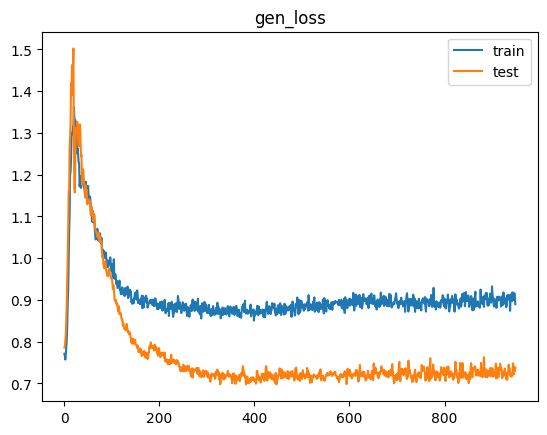

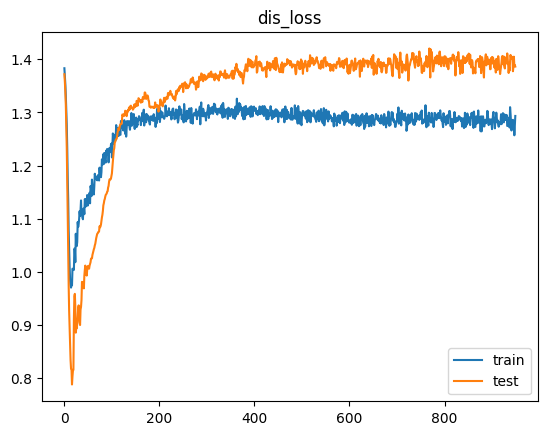

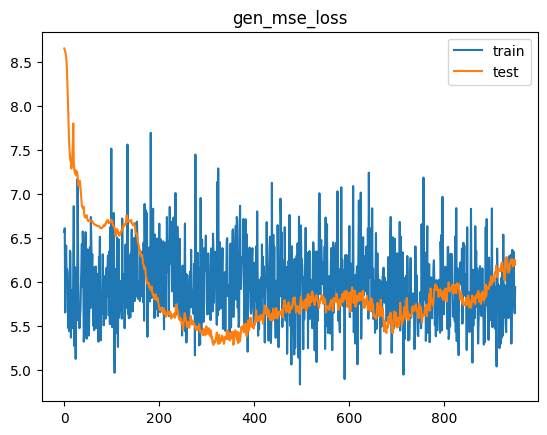

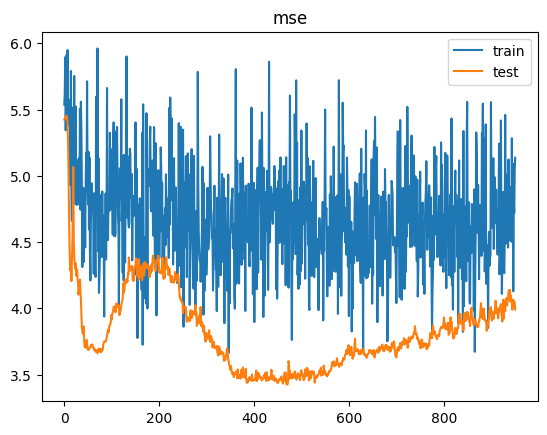

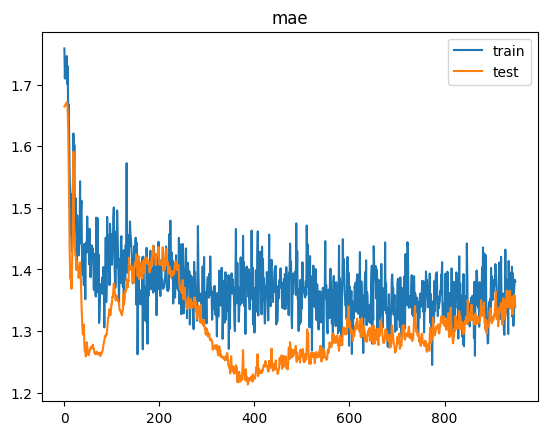

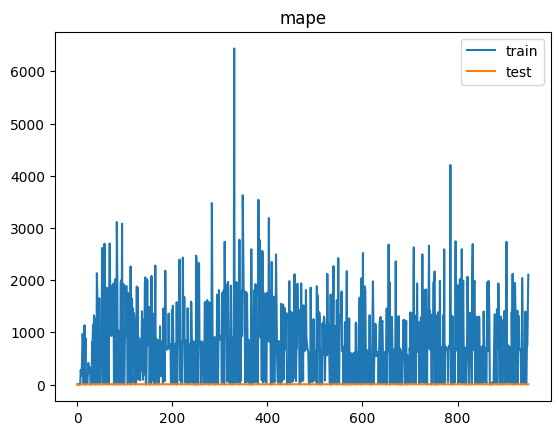

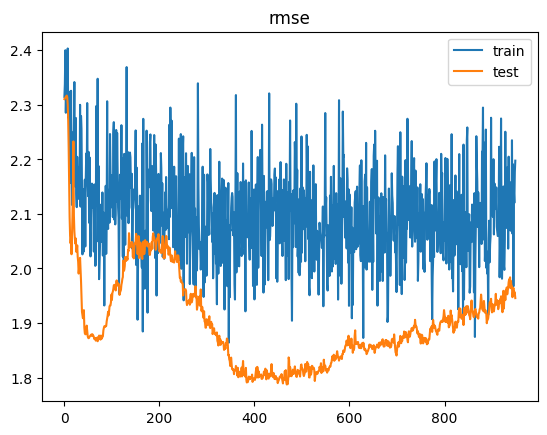

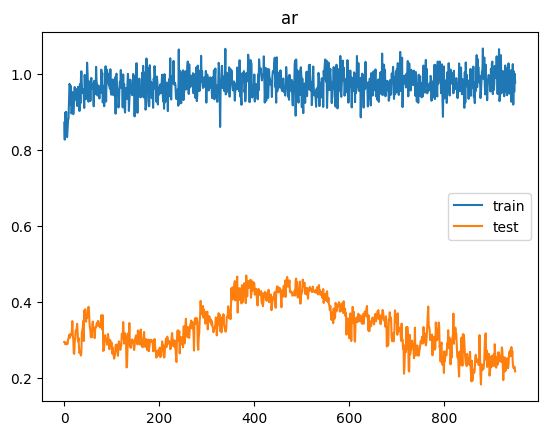

2/2 [==============================] - 0s 3ms/step


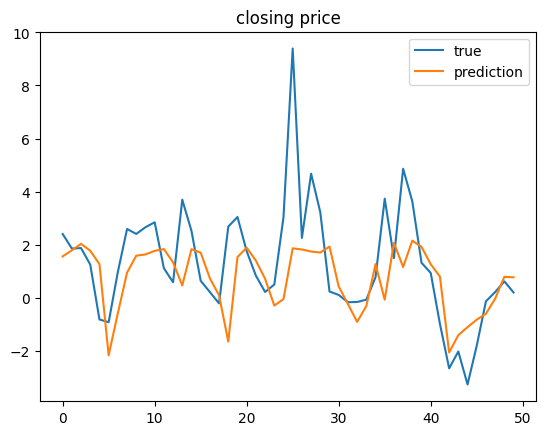

[MSE Baseline] train: 4.321040563206593  test: 3.7469059248471765
Delta time with epochs = 950: 0:07:45.370356
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_8 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_8 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_9 (GRU)  

Time for epoch 52 is 0.4436047077178955 sec Generator Loss: 1.6313456296920776,  Discriminator_loss: 0.9498464465141296
Time for epoch 53 is 0.4576854705810547 sec Generator Loss: 1.7027502059936523,  Discriminator_loss: 0.9408518075942993
Time for epoch 54 is 0.46489477157592773 sec Generator Loss: 1.6637365818023682,  Discriminator_loss: 0.9280334115028381
Time for epoch 55 is 0.4553964138031006 sec Generator Loss: 1.714245080947876,  Discriminator_loss: 0.9253153800964355
Time for epoch 56 is 0.45996999740600586 sec Generator Loss: 1.6682430505752563,  Discriminator_loss: 0.9310227036476135
Time for epoch 57 is 0.4500613212585449 sec Generator Loss: 1.6845195293426514,  Discriminator_loss: 0.949067234992981
Time for epoch 58 is 0.47053098678588867 sec Generator Loss: 1.6433261632919312,  Discriminator_loss: 0.9423550367355347
Time for epoch 59 is 0.4381430149078369 sec Generator Loss: 1.6941062211990356,  Discriminator_loss: 0.9332931637763977
Time for epoch 60 is 0.4974565505981445

Time for epoch 121 is 0.4390242099761963 sec Generator Loss: 1.1074228286743164,  Discriminator_loss: 1.1820870637893677
Time for epoch 122 is 0.4282548427581787 sec Generator Loss: 1.1261202096939087,  Discriminator_loss: 1.1470087766647339
Time for epoch 123 is 0.4330756664276123 sec Generator Loss: 1.1342192888259888,  Discriminator_loss: 1.1418465375900269
Time for epoch 124 is 0.43058061599731445 sec Generator Loss: 1.128934621810913,  Discriminator_loss: 1.1565021276474
Time for epoch 125 is 0.4337329864501953 sec Generator Loss: 1.1289933919906616,  Discriminator_loss: 1.1665349006652832
Time for epoch 126 is 0.42696189880371094 sec Generator Loss: 1.1449753046035767,  Discriminator_loss: 1.1408015489578247
Time for epoch 127 is 0.4287223815917969 sec Generator Loss: 1.1467254161834717,  Discriminator_loss: 1.1671229600906372
Time for epoch 128 is 0.45411205291748047 sec Generator Loss: 1.1086132526397705,  Discriminator_loss: 1.189638614654541
Time for epoch 129 is 0.4346296787

Time for epoch 189 is 0.43877220153808594 sec Generator Loss: 0.9807745218276978,  Discriminator_loss: 1.2472045421600342
Time for epoch 190 is 0.4548945426940918 sec Generator Loss: 0.9581813812255859,  Discriminator_loss: 1.261521816253662
Time for epoch 191 is 0.4333760738372803 sec Generator Loss: 0.9702394008636475,  Discriminator_loss: 1.2461340427398682
Time for epoch 192 is 0.43607306480407715 sec Generator Loss: 0.977268636226654,  Discriminator_loss: 1.256459355354309
Time for epoch 193 is 0.42839765548706055 sec Generator Loss: 0.9512098431587219,  Discriminator_loss: 1.272236943244934
Time for epoch 194 is 0.4327266216278076 sec Generator Loss: 0.9708803296089172,  Discriminator_loss: 1.2477113008499146
Time for epoch 195 is 0.43588757514953613 sec Generator Loss: 0.964859664440155,  Discriminator_loss: 1.2631280422210693
Time for epoch 196 is 0.4397470951080322 sec Generator Loss: 0.9468892216682434,  Discriminator_loss: 1.2670838832855225
Time for epoch 197 is 0.438819885

Time for epoch 257 is 0.47803521156311035 sec Generator Loss: 0.9386497139930725,  Discriminator_loss: 1.2617932558059692
Time for epoch 258 is 0.5038893222808838 sec Generator Loss: 0.9211503863334656,  Discriminator_loss: 1.2703088521957397
Time for epoch 259 is 0.43323469161987305 sec Generator Loss: 0.971467912197113,  Discriminator_loss: 1.2673033475875854
Time for epoch 260 is 0.42804837226867676 sec Generator Loss: 0.945640504360199,  Discriminator_loss: 1.2650609016418457
Time for epoch 261 is 0.42629432678222656 sec Generator Loss: 0.9364292621612549,  Discriminator_loss: 1.2686632871627808
Time for epoch 262 is 0.42991161346435547 sec Generator Loss: 0.9609094262123108,  Discriminator_loss: 1.26016366481781
Time for epoch 263 is 0.42943286895751953 sec Generator Loss: 0.9533741474151611,  Discriminator_loss: 1.2689372301101685
Time for epoch 264 is 0.443988561630249 sec Generator Loss: 0.9474586248397827,  Discriminator_loss: 1.2692792415618896
Time for epoch 265 is 0.4462068

Time for epoch 325 is 0.4294157028198242 sec Generator Loss: 0.9537566900253296,  Discriminator_loss: 1.2654411792755127
Time for epoch 326 is 0.4409523010253906 sec Generator Loss: 0.953637957572937,  Discriminator_loss: 1.2673360109329224
Time for epoch 327 is 0.42688608169555664 sec Generator Loss: 0.923514187335968,  Discriminator_loss: 1.2659122943878174
Time for epoch 328 is 0.4317209720611572 sec Generator Loss: 0.9422157406806946,  Discriminator_loss: 1.2637900114059448
Time for epoch 329 is 0.43073415756225586 sec Generator Loss: 0.9509446024894714,  Discriminator_loss: 1.2763912677764893
Time for epoch 330 is 0.43417859077453613 sec Generator Loss: 0.938570499420166,  Discriminator_loss: 1.2709776163101196
Time for epoch 331 is 0.4283294677734375 sec Generator Loss: 0.9213732481002808,  Discriminator_loss: 1.2748140096664429
Time for epoch 332 is 0.43603968620300293 sec Generator Loss: 0.932067334651947,  Discriminator_loss: 1.272489309310913
Time for epoch 333 is 0.439095973

Time for epoch 393 is 0.436007022857666 sec Generator Loss: 0.9277408123016357,  Discriminator_loss: 1.272995114326477
Time for epoch 394 is 0.44437146186828613 sec Generator Loss: 0.9300729036331177,  Discriminator_loss: 1.2727075815200806
Time for epoch 395 is 0.45497965812683105 sec Generator Loss: 0.9195003509521484,  Discriminator_loss: 1.2743206024169922
Time for epoch 396 is 0.45530176162719727 sec Generator Loss: 0.921113908290863,  Discriminator_loss: 1.2684141397476196
Time for epoch 397 is 0.49479079246520996 sec Generator Loss: 0.9146783351898193,  Discriminator_loss: 1.2796982526779175
Time for epoch 398 is 0.46558403968811035 sec Generator Loss: 0.9232853055000305,  Discriminator_loss: 1.2778264284133911
Time for epoch 399 is 0.45852065086364746 sec Generator Loss: 0.9253460764884949,  Discriminator_loss: 1.2700163125991821
Time for epoch 400 is 0.4566926956176758 sec Generator Loss: 0.9424939155578613,  Discriminator_loss: 1.2679822444915771
Time for epoch 401 is 0.47680

Time for epoch 461 is 0.4362456798553467 sec Generator Loss: 0.9347402453422546,  Discriminator_loss: 1.2894072532653809
Time for epoch 462 is 0.444124698638916 sec Generator Loss: 0.9268641471862793,  Discriminator_loss: 1.2829004526138306
Time for epoch 463 is 0.43633413314819336 sec Generator Loss: 0.950972855091095,  Discriminator_loss: 1.2632173299789429
Time for epoch 464 is 0.43465495109558105 sec Generator Loss: 0.9414137601852417,  Discriminator_loss: 1.262434482574463
Time for epoch 465 is 0.45035219192504883 sec Generator Loss: 0.931377112865448,  Discriminator_loss: 1.2869082689285278
Time for epoch 466 is 0.44290614128112793 sec Generator Loss: 0.9429739117622375,  Discriminator_loss: 1.261807918548584
Time for epoch 467 is 0.4410114288330078 sec Generator Loss: 0.9202958345413208,  Discriminator_loss: 1.2793660163879395
Time for epoch 468 is 0.44229793548583984 sec Generator Loss: 0.9268174171447754,  Discriminator_loss: 1.2772399187088013
Time for epoch 469 is 0.43781661

Time for epoch 529 is 0.4393436908721924 sec Generator Loss: 0.9454954862594604,  Discriminator_loss: 1.262565016746521
Time for epoch 530 is 0.43393397331237793 sec Generator Loss: 0.9514274001121521,  Discriminator_loss: 1.2584645748138428
Time for epoch 531 is 0.43547606468200684 sec Generator Loss: 0.961166501045227,  Discriminator_loss: 1.2598923444747925
Time for epoch 532 is 0.4511687755584717 sec Generator Loss: 0.9665017127990723,  Discriminator_loss: 1.266255497932434
Time for epoch 533 is 0.4389760494232178 sec Generator Loss: 0.954542875289917,  Discriminator_loss: 1.2668713331222534
Time for epoch 534 is 0.44551563262939453 sec Generator Loss: 0.9395501613616943,  Discriminator_loss: 1.266123652458191
Time for epoch 535 is 0.4650909900665283 sec Generator Loss: 0.935975968837738,  Discriminator_loss: 1.2784206867218018
Time for epoch 536 is 0.448591947555542 sec Generator Loss: 0.9271746873855591,  Discriminator_loss: 1.2763899564743042
Time for epoch 537 is 0.441126585006

Time for epoch 597 is 0.43524694442749023 sec Generator Loss: 0.9681253433227539,  Discriminator_loss: 1.250295639038086
Time for epoch 598 is 0.4368410110473633 sec Generator Loss: 0.9730665683746338,  Discriminator_loss: 1.2476221323013306
Time for epoch 599 is 0.4478428363800049 sec Generator Loss: 0.9397326707839966,  Discriminator_loss: 1.2697690725326538
Time for epoch 600 is 0.43780016899108887 sec Generator Loss: 0.9570171236991882,  Discriminator_loss: 1.2591915130615234
Time for epoch 601 is 0.44310951232910156 sec Generator Loss: 0.9443984031677246,  Discriminator_loss: 1.2687932252883911
Time for epoch 602 is 0.4348273277282715 sec Generator Loss: 0.9377331733703613,  Discriminator_loss: 1.265276551246643
Time for epoch 603 is 0.4648139476776123 sec Generator Loss: 0.9499766230583191,  Discriminator_loss: 1.255817174911499
Time for epoch 604 is 0.4429187774658203 sec Generator Loss: 0.9592874050140381,  Discriminator_loss: 1.2710168361663818
Time for epoch 605 is 0.43655991

Time for epoch 665 is 0.4438140392303467 sec Generator Loss: 0.9544355273246765,  Discriminator_loss: 1.2454420328140259
Time for epoch 666 is 0.44527435302734375 sec Generator Loss: 0.9567580819129944,  Discriminator_loss: 1.2537716627120972
Time for epoch 667 is 0.4429340362548828 sec Generator Loss: 0.971057653427124,  Discriminator_loss: 1.2401894330978394
Time for epoch 668 is 0.4536013603210449 sec Generator Loss: 0.9651197195053101,  Discriminator_loss: 1.2508478164672852
Time for epoch 669 is 0.4411005973815918 sec Generator Loss: 0.9736055135726929,  Discriminator_loss: 1.2563952207565308
Time for epoch 670 is 0.43633127212524414 sec Generator Loss: 0.9511200189590454,  Discriminator_loss: 1.2609035968780518
Time for epoch 671 is 0.4366328716278076 sec Generator Loss: 0.9729835987091064,  Discriminator_loss: 1.244942545890808
Time for epoch 672 is 0.43314647674560547 sec Generator Loss: 0.9512456655502319,  Discriminator_loss: 1.257399559020996
Time for epoch 673 is 0.44239187

Time for epoch 733 is 0.43369340896606445 sec Generator Loss: 0.9849985241889954,  Discriminator_loss: 1.2431641817092896
Time for epoch 734 is 0.4441993236541748 sec Generator Loss: 0.9790517687797546,  Discriminator_loss: 1.2644709348678589
Time for epoch 735 is 0.43720340728759766 sec Generator Loss: 0.9557211995124817,  Discriminator_loss: 1.2621461153030396
Time for epoch 736 is 0.45932888984680176 sec Generator Loss: 0.9426817893981934,  Discriminator_loss: 1.2751718759536743
Time for epoch 737 is 0.4313802719116211 sec Generator Loss: 0.97004634141922,  Discriminator_loss: 1.2604081630706787
Time for epoch 738 is 0.4367055892944336 sec Generator Loss: 0.961097240447998,  Discriminator_loss: 1.2454694509506226
Time for epoch 739 is 0.44468140602111816 sec Generator Loss: 0.9628550410270691,  Discriminator_loss: 1.246236801147461
Time for epoch 740 is 0.4350264072418213 sec Generator Loss: 0.9548254013061523,  Discriminator_loss: 1.2605006694793701
Time for epoch 741 is 0.43597269

Time for epoch 801 is 0.43425536155700684 sec Generator Loss: 1.0034922361373901,  Discriminator_loss: 1.2294509410858154
Time for epoch 802 is 0.4326164722442627 sec Generator Loss: 0.988091766834259,  Discriminator_loss: 1.2436599731445312
Time for epoch 803 is 0.43610548973083496 sec Generator Loss: 0.9643839597702026,  Discriminator_loss: 1.2427111864089966
Time for epoch 804 is 0.43758559226989746 sec Generator Loss: 0.9888809323310852,  Discriminator_loss: 1.2324987649917603
Time for epoch 805 is 0.44758009910583496 sec Generator Loss: 0.982856810092926,  Discriminator_loss: 1.2481023073196411
Time for epoch 806 is 0.4286012649536133 sec Generator Loss: 0.9811099767684937,  Discriminator_loss: 1.2520121335983276
Time for epoch 807 is 0.44428038597106934 sec Generator Loss: 0.9703903198242188,  Discriminator_loss: 1.252708077430725
Time for epoch 808 is 0.4299287796020508 sec Generator Loss: 0.9699341058731079,  Discriminator_loss: 1.27351975440979
Time for epoch 809 is 0.43483448

Time for epoch 869 is 0.4346041679382324 sec Generator Loss: 0.9667797088623047,  Discriminator_loss: 1.2534419298171997
Time for epoch 870 is 0.49976134300231934 sec Generator Loss: 0.9651056528091431,  Discriminator_loss: 1.2569067478179932
Time for epoch 871 is 0.44396185874938965 sec Generator Loss: 0.9843989014625549,  Discriminator_loss: 1.2506694793701172
Time for epoch 872 is 0.4650154113769531 sec Generator Loss: 0.9674946069717407,  Discriminator_loss: 1.2491730451583862
Time for epoch 873 is 0.4387185573577881 sec Generator Loss: 1.0022737979888916,  Discriminator_loss: 1.2406753301620483
Time for epoch 874 is 0.47248005867004395 sec Generator Loss: 0.9855055809020996,  Discriminator_loss: 1.2425605058670044
Time for epoch 875 is 0.46477723121643066 sec Generator Loss: 0.9833500385284424,  Discriminator_loss: 1.245867133140564
Time for epoch 876 is 0.4772040843963623 sec Generator Loss: 0.9748320579528809,  Discriminator_loss: 1.2602516412734985
Time for epoch 877 is 0.44635

Time for epoch 937 is 0.43191027641296387 sec Generator Loss: 0.986545979976654,  Discriminator_loss: 1.255946159362793
Time for epoch 938 is 0.4368147850036621 sec Generator Loss: 0.9529290199279785,  Discriminator_loss: 1.270925760269165
Time for epoch 939 is 0.45067691802978516 sec Generator Loss: 0.97335284948349,  Discriminator_loss: 1.2686967849731445
Time for epoch 940 is 0.46894335746765137 sec Generator Loss: 0.9575677514076233,  Discriminator_loss: 1.253482699394226
Time for epoch 941 is 0.44096875190734863 sec Generator Loss: 0.9799685478210449,  Discriminator_loss: 1.270499348640442
Time for epoch 942 is 0.4506676197052002 sec Generator Loss: 0.9814768433570862,  Discriminator_loss: 1.2425508499145508
Time for epoch 943 is 0.4545888900756836 sec Generator Loss: 0.9809205532073975,  Discriminator_loss: 1.254892349243164
Time for epoch 944 is 0.4425783157348633 sec Generator Loss: 0.9738770723342896,  Discriminator_loss: 1.2461750507354736
Time for epoch 945 is 0.435201883316

Time for epoch 1005 is 0.477755069732666 sec Generator Loss: 0.9776319265365601,  Discriminator_loss: 1.2508773803710938
Time for epoch 1006 is 0.48423218727111816 sec Generator Loss: 0.9462386965751648,  Discriminator_loss: 1.2618714570999146
Time for epoch 1007 is 0.4842801094055176 sec Generator Loss: 0.9560064077377319,  Discriminator_loss: 1.2640016078948975
Time for epoch 1008 is 0.4998157024383545 sec Generator Loss: 0.9775629043579102,  Discriminator_loss: 1.2631869316101074
Time for epoch 1009 is 0.5008571147918701 sec Generator Loss: 0.9822478890419006,  Discriminator_loss: 1.2519757747650146
Time for epoch 1010 is 0.48398399353027344 sec Generator Loss: 0.9720808863639832,  Discriminator_loss: 1.255661129951477
Time for epoch 1011 is 0.47833728790283203 sec Generator Loss: 0.9694093465805054,  Discriminator_loss: 1.2545580863952637
Time for epoch 1012 is 0.4939606189727783 sec Generator Loss: 0.9572716355323792,  Discriminator_loss: 1.2728476524353027
Time for epoch 1013 is 

Time for epoch 1073 is 0.5201740264892578 sec Generator Loss: 0.9670905470848083,  Discriminator_loss: 1.2630380392074585
Time for epoch 1074 is 0.4900038242340088 sec Generator Loss: 0.9985812902450562,  Discriminator_loss: 1.2327401638031006
Time for epoch 1075 is 0.49491286277770996 sec Generator Loss: 0.9878117442131042,  Discriminator_loss: 1.2526344060897827
Time for epoch 1076 is 0.48906612396240234 sec Generator Loss: 0.9923369288444519,  Discriminator_loss: 1.2456525564193726
Time for epoch 1077 is 0.4890310764312744 sec Generator Loss: 0.9779415130615234,  Discriminator_loss: 1.251896619796753
Time for epoch 1078 is 0.49610304832458496 sec Generator Loss: 0.9596452116966248,  Discriminator_loss: 1.25936758518219
Time for epoch 1079 is 0.4942309856414795 sec Generator Loss: 0.9592345952987671,  Discriminator_loss: 1.267945408821106
Time for epoch 1080 is 0.48485708236694336 sec Generator Loss: 0.9548214673995972,  Discriminator_loss: 1.2684890031814575
Time for epoch 1081 is 0

Time for epoch 1141 is 0.5474808216094971 sec Generator Loss: 0.94305819272995,  Discriminator_loss: 1.2683587074279785
Time for epoch 1142 is 0.480074405670166 sec Generator Loss: 0.9623034596443176,  Discriminator_loss: 1.284528374671936
Time for epoch 1143 is 0.47312307357788086 sec Generator Loss: 0.9461272954940796,  Discriminator_loss: 1.2747989892959595
Time for epoch 1144 is 0.4717881679534912 sec Generator Loss: 0.952385425567627,  Discriminator_loss: 1.2739253044128418
Time for epoch 1145 is 0.4527163505554199 sec Generator Loss: 0.949414074420929,  Discriminator_loss: 1.2658754587173462
Time for epoch 1146 is 0.44765186309814453 sec Generator Loss: 0.9511579275131226,  Discriminator_loss: 1.2580927610397339
Time for epoch 1147 is 0.44697999954223633 sec Generator Loss: 0.9542913436889648,  Discriminator_loss: 1.2589317560195923
Time for epoch 1148 is 0.454038143157959 sec Generator Loss: 0.9524073600769043,  Discriminator_loss: 1.2856431007385254
Time for epoch 1149 is 0.449

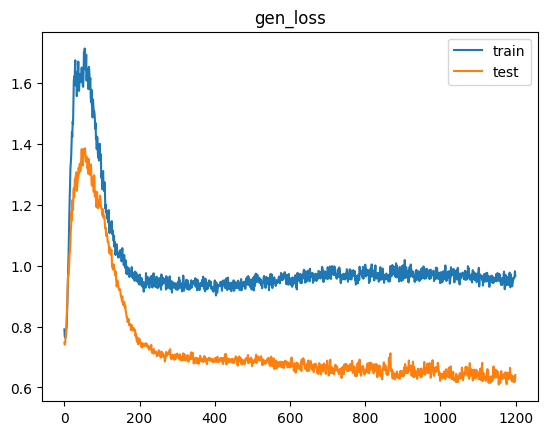

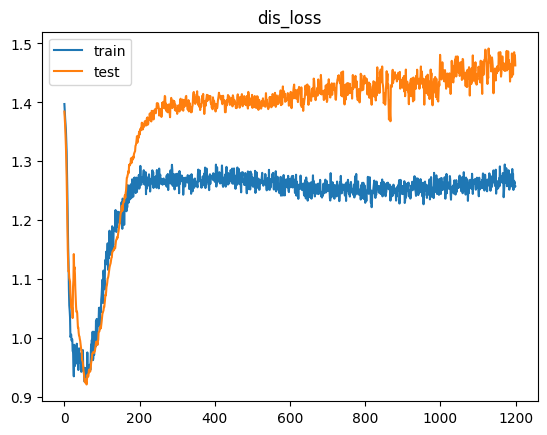

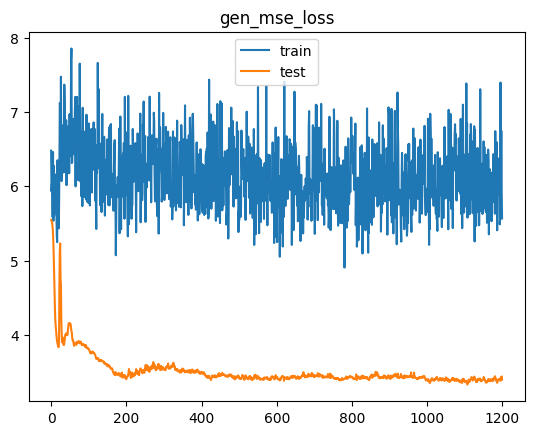

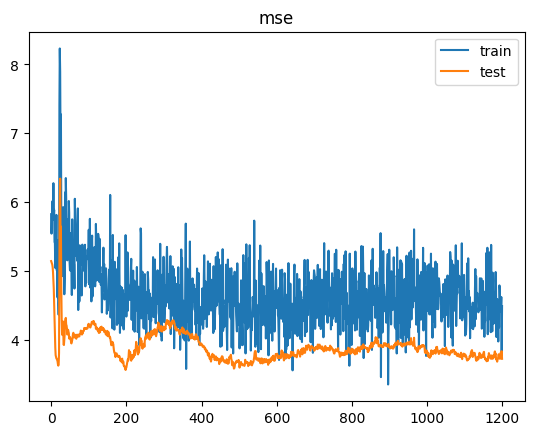

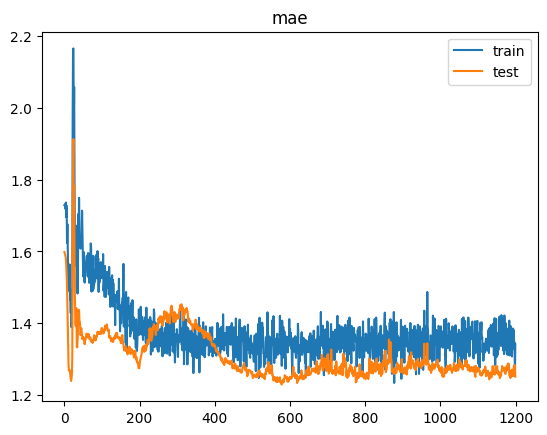

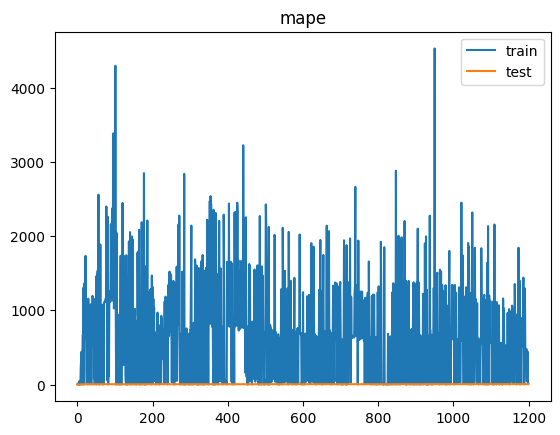

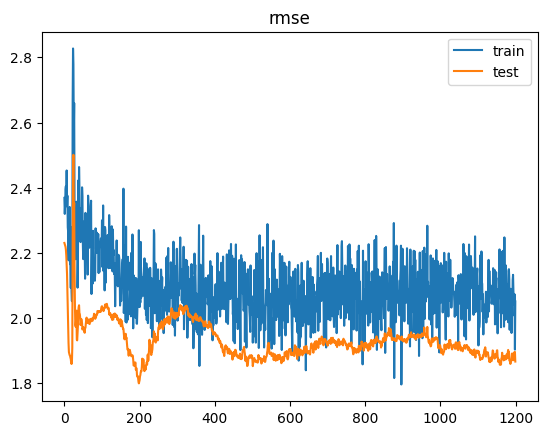

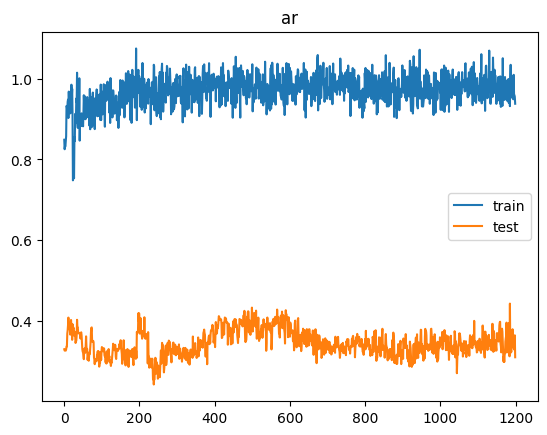

2/2 [==============================] - 0s 4ms/step


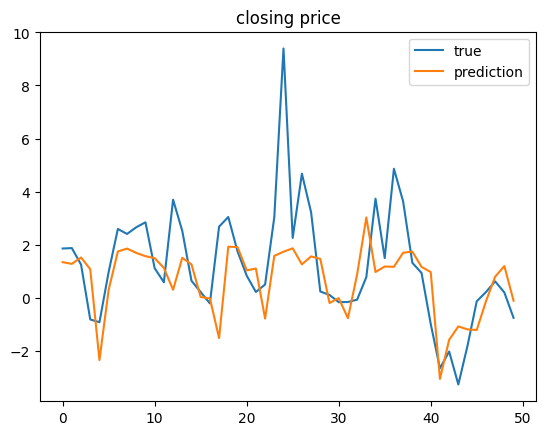

[MSE Baseline] train: 4.177986193993428  test: 3.665913330963867
Delta time with epochs = 1200: 0:09:22.787924
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_10 (GRU)                (None, 5, 10)             570       
                                                                 
 batch_normalization_10 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_11 (GRU) 

Time for epoch 52 is 0.4681661128997803 sec Generator Loss: 1.3370689153671265,  Discriminator_loss: 0.9820753335952759
Time for epoch 53 is 0.4793062210083008 sec Generator Loss: 1.3341091871261597,  Discriminator_loss: 0.9783397316932678
Time for epoch 54 is 0.5073485374450684 sec Generator Loss: 1.3028059005737305,  Discriminator_loss: 1.0213006734848022
Time for epoch 55 is 0.47407078742980957 sec Generator Loss: 1.3179782629013062,  Discriminator_loss: 0.9829978942871094
Time for epoch 56 is 0.46996378898620605 sec Generator Loss: 1.3188014030456543,  Discriminator_loss: 0.9873714447021484
Time for epoch 57 is 0.4875314235687256 sec Generator Loss: 1.2943142652511597,  Discriminator_loss: 1.021472454071045
Time for epoch 58 is 0.4713003635406494 sec Generator Loss: 1.3036681413650513,  Discriminator_loss: 1.0071848630905151
Time for epoch 59 is 0.47401976585388184 sec Generator Loss: 1.2733453512191772,  Discriminator_loss: 1.0185381174087524
Time for epoch 60 is 0.464823484420776

Time for epoch 121 is 0.4751017093658447 sec Generator Loss: 0.9768406748771667,  Discriminator_loss: 1.2260332107543945
Time for epoch 122 is 0.48900318145751953 sec Generator Loss: 0.9674239158630371,  Discriminator_loss: 1.2251160144805908
Time for epoch 123 is 0.47000718116760254 sec Generator Loss: 0.9840160608291626,  Discriminator_loss: 1.208764672279358
Time for epoch 124 is 0.520000696182251 sec Generator Loss: 0.9637652635574341,  Discriminator_loss: 1.235361933708191
Time for epoch 125 is 0.47191643714904785 sec Generator Loss: 0.9622461199760437,  Discriminator_loss: 1.2273428440093994
Time for epoch 126 is 0.45688390731811523 sec Generator Loss: 0.9629201292991638,  Discriminator_loss: 1.226091980934143
Time for epoch 127 is 0.4915328025817871 sec Generator Loss: 0.9619907140731812,  Discriminator_loss: 1.2266209125518799
Time for epoch 128 is 0.462299108505249 sec Generator Loss: 0.9469062685966492,  Discriminator_loss: 1.2273998260498047
Time for epoch 129 is 0.466138601

Time for epoch 189 is 0.4672110080718994 sec Generator Loss: 0.9006299376487732,  Discriminator_loss: 1.2776967287063599
Time for epoch 190 is 0.4965653419494629 sec Generator Loss: 0.911547064781189,  Discriminator_loss: 1.2837703227996826
Time for epoch 191 is 0.4704446792602539 sec Generator Loss: 0.9177671074867249,  Discriminator_loss: 1.2714952230453491
Time for epoch 192 is 0.4666881561279297 sec Generator Loss: 0.9077382683753967,  Discriminator_loss: 1.275607705116272
Time for epoch 193 is 0.5044128894805908 sec Generator Loss: 0.9034935832023621,  Discriminator_loss: 1.2822679281234741
Time for epoch 194 is 0.46595311164855957 sec Generator Loss: 0.911030113697052,  Discriminator_loss: 1.2696855068206787
Time for epoch 195 is 0.4673445224761963 sec Generator Loss: 0.9201838970184326,  Discriminator_loss: 1.2720253467559814
Time for epoch 196 is 0.4696803092956543 sec Generator Loss: 0.9134523272514343,  Discriminator_loss: 1.2768892049789429
Time for epoch 197 is 0.5441744327

Time for epoch 257 is 0.4683187007904053 sec Generator Loss: 0.8982133865356445,  Discriminator_loss: 1.2751446962356567
Time for epoch 258 is 0.5019176006317139 sec Generator Loss: 0.9047964811325073,  Discriminator_loss: 1.2761026620864868
Time for epoch 259 is 0.4708991050720215 sec Generator Loss: 0.9018700122833252,  Discriminator_loss: 1.2870193719863892
Time for epoch 260 is 0.47327446937561035 sec Generator Loss: 0.9120780229568481,  Discriminator_loss: 1.2717636823654175
Time for epoch 261 is 0.5267386436462402 sec Generator Loss: 0.8920791745185852,  Discriminator_loss: 1.2977427244186401
Time for epoch 262 is 0.48354649543762207 sec Generator Loss: 0.8907151222229004,  Discriminator_loss: 1.2945243120193481
Time for epoch 263 is 0.4746513366699219 sec Generator Loss: 0.8871985077857971,  Discriminator_loss: 1.2851200103759766
Time for epoch 264 is 0.4792795181274414 sec Generator Loss: 0.9012771248817444,  Discriminator_loss: 1.280668020248413
Time for epoch 265 is 0.4687592

Time for epoch 325 is 0.46541666984558105 sec Generator Loss: 0.8970527648925781,  Discriminator_loss: 1.292177677154541
Time for epoch 326 is 0.4682178497314453 sec Generator Loss: 0.8987945914268494,  Discriminator_loss: 1.2863608598709106
Time for epoch 327 is 0.4875955581665039 sec Generator Loss: 0.8989242911338806,  Discriminator_loss: 1.2887074947357178
Time for epoch 328 is 0.5023417472839355 sec Generator Loss: 0.8997752666473389,  Discriminator_loss: 1.2857670783996582
Time for epoch 329 is 0.4683372974395752 sec Generator Loss: 0.9071770906448364,  Discriminator_loss: 1.2738564014434814
Time for epoch 330 is 0.4929351806640625 sec Generator Loss: 0.8828809261322021,  Discriminator_loss: 1.2917416095733643
Time for epoch 331 is 0.466015100479126 sec Generator Loss: 0.9073987007141113,  Discriminator_loss: 1.283093810081482
Time for epoch 332 is 0.498460054397583 sec Generator Loss: 0.897998034954071,  Discriminator_loss: 1.274580717086792
Time for epoch 333 is 0.4993889331817

Time for epoch 393 is 0.4668128490447998 sec Generator Loss: 0.8940019607543945,  Discriminator_loss: 1.2912133932113647
Time for epoch 394 is 0.4868922233581543 sec Generator Loss: 0.8936455845832825,  Discriminator_loss: 1.2874391078948975
Time for epoch 395 is 0.46608424186706543 sec Generator Loss: 0.8875241875648499,  Discriminator_loss: 1.3050848245620728
Time for epoch 396 is 0.476970911026001 sec Generator Loss: 0.8841956257820129,  Discriminator_loss: 1.2985528707504272
Time for epoch 397 is 0.4833710193634033 sec Generator Loss: 0.9085007905960083,  Discriminator_loss: 1.2872910499572754
Time for epoch 398 is 0.47539806365966797 sec Generator Loss: 0.8892877697944641,  Discriminator_loss: 1.285670280456543
Time for epoch 399 is 0.4699528217315674 sec Generator Loss: 0.9063349366188049,  Discriminator_loss: 1.2897429466247559
Time for epoch 400 is 0.49088382720947266 sec Generator Loss: 0.8775999546051025,  Discriminator_loss: 1.2913306951522827
Time for epoch 401 is 0.4671752

Time for epoch 461 is 0.46562719345092773 sec Generator Loss: 0.8864120244979858,  Discriminator_loss: 1.3076207637786865
Time for epoch 462 is 0.46401262283325195 sec Generator Loss: 0.877925455570221,  Discriminator_loss: 1.3016740083694458
Time for epoch 463 is 0.47347211837768555 sec Generator Loss: 0.8652473092079163,  Discriminator_loss: 1.3056602478027344
Time for epoch 464 is 0.4699974060058594 sec Generator Loss: 0.9079933762550354,  Discriminator_loss: 1.281434416770935
Time for epoch 465 is 0.4914429187774658 sec Generator Loss: 0.8890154957771301,  Discriminator_loss: 1.2942438125610352
Time for epoch 466 is 0.4812963008880615 sec Generator Loss: 0.8958314657211304,  Discriminator_loss: 1.2970422506332397
Time for epoch 467 is 0.4815390110015869 sec Generator Loss: 0.8831871151924133,  Discriminator_loss: 1.2909297943115234
Time for epoch 468 is 0.47882628440856934 sec Generator Loss: 0.89295494556427,  Discriminator_loss: 1.2843952178955078
Time for epoch 469 is 0.46714282

Time for epoch 529 is 0.5539770126342773 sec Generator Loss: 0.8810976147651672,  Discriminator_loss: 1.294957160949707
Time for epoch 530 is 0.5195045471191406 sec Generator Loss: 0.8998762369155884,  Discriminator_loss: 1.302248477935791
Time for epoch 531 is 0.508169412612915 sec Generator Loss: 0.8990911245346069,  Discriminator_loss: 1.2958556413650513
Time for epoch 532 is 0.504716157913208 sec Generator Loss: 0.8992019891738892,  Discriminator_loss: 1.2871841192245483
Time for epoch 533 is 0.5025944709777832 sec Generator Loss: 0.9024680256843567,  Discriminator_loss: 1.2921228408813477
Time for epoch 534 is 0.509315013885498 sec Generator Loss: 0.9137464761734009,  Discriminator_loss: 1.2910181283950806
Time for epoch 535 is 0.5155413150787354 sec Generator Loss: 0.8905015587806702,  Discriminator_loss: 1.3078759908676147
Time for epoch 536 is 0.5109808444976807 sec Generator Loss: 0.8879404067993164,  Discriminator_loss: 1.302704930305481
Time for epoch 537 is 0.52184700965881

Time for epoch 597 is 0.48067235946655273 sec Generator Loss: 0.9157782793045044,  Discriminator_loss: 1.284368872642517
Time for epoch 598 is 0.47760486602783203 sec Generator Loss: 0.902225136756897,  Discriminator_loss: 1.2827379703521729
Time for epoch 599 is 0.4803943634033203 sec Generator Loss: 0.9086560606956482,  Discriminator_loss: 1.2855008840560913
Time for epoch 600 is 0.48690366744995117 sec Generator Loss: 0.8937175869941711,  Discriminator_loss: 1.2888542413711548
Time for epoch 601 is 0.47389650344848633 sec Generator Loss: 0.8912109732627869,  Discriminator_loss: 1.3055458068847656
Time for epoch 602 is 0.47287726402282715 sec Generator Loss: 0.9179674983024597,  Discriminator_loss: 1.2927359342575073
Time for epoch 603 is 0.4767014980316162 sec Generator Loss: 0.9195664525032043,  Discriminator_loss: 1.276482105255127
Time for epoch 604 is 0.48499178886413574 sec Generator Loss: 0.8924351930618286,  Discriminator_loss: 1.2985936403274536
Time for epoch 605 is 0.47861

Time for epoch 665 is 0.47280335426330566 sec Generator Loss: 0.8843162655830383,  Discriminator_loss: 1.2898943424224854
Time for epoch 666 is 0.49030542373657227 sec Generator Loss: 0.8961678743362427,  Discriminator_loss: 1.2880505323410034
Time for epoch 667 is 0.47093677520751953 sec Generator Loss: 0.8947837352752686,  Discriminator_loss: 1.2915445566177368
Time for epoch 668 is 0.48800206184387207 sec Generator Loss: 0.8775796890258789,  Discriminator_loss: 1.31143057346344
Time for epoch 669 is 0.4750850200653076 sec Generator Loss: 0.8900718688964844,  Discriminator_loss: 1.2852963209152222
Time for epoch 670 is 0.47226858139038086 sec Generator Loss: 0.8945407867431641,  Discriminator_loss: 1.2931102514266968
Time for epoch 671 is 0.47545790672302246 sec Generator Loss: 0.8981162905693054,  Discriminator_loss: 1.2883644104003906
Time for epoch 672 is 0.4692833423614502 sec Generator Loss: 0.8916119933128357,  Discriminator_loss: 1.2896580696105957
Time for epoch 673 is 0.4881

Time for epoch 733 is 0.48281383514404297 sec Generator Loss: 0.9197070598602295,  Discriminator_loss: 1.277845025062561
Time for epoch 734 is 0.48888564109802246 sec Generator Loss: 0.9296271204948425,  Discriminator_loss: 1.275262713432312
Time for epoch 735 is 0.4808473587036133 sec Generator Loss: 0.9229784607887268,  Discriminator_loss: 1.2769817113876343
Time for epoch 736 is 0.4705824851989746 sec Generator Loss: 0.9087755084037781,  Discriminator_loss: 1.2884358167648315
Time for epoch 737 is 0.4876282215118408 sec Generator Loss: 0.9133641719818115,  Discriminator_loss: 1.2807453870773315
Time for epoch 738 is 0.50724196434021 sec Generator Loss: 0.9052413702011108,  Discriminator_loss: 1.2910083532333374
Time for epoch 739 is 0.5085155963897705 sec Generator Loss: 0.9040505886077881,  Discriminator_loss: 1.28621244430542
Time for epoch 740 is 0.4744284152984619 sec Generator Loss: 0.9320317506790161,  Discriminator_loss: 1.2684636116027832
Time for epoch 741 is 0.483340740203

Time for epoch 801 is 0.4969806671142578 sec Generator Loss: 0.9133187532424927,  Discriminator_loss: 1.283071517944336
Time for epoch 802 is 0.48433685302734375 sec Generator Loss: 0.9287314414978027,  Discriminator_loss: 1.2774243354797363
Time for epoch 803 is 0.4862356185913086 sec Generator Loss: 0.9017715454101562,  Discriminator_loss: 1.2927418947219849
Time for epoch 804 is 0.4850594997406006 sec Generator Loss: 0.9072873592376709,  Discriminator_loss: 1.2802225351333618
Time for epoch 805 is 0.4866647720336914 sec Generator Loss: 0.9197049140930176,  Discriminator_loss: 1.2787419557571411
Time for epoch 806 is 0.504995584487915 sec Generator Loss: 0.9151651859283447,  Discriminator_loss: 1.2719626426696777
Time for epoch 807 is 0.4902646541595459 sec Generator Loss: 0.9039755463600159,  Discriminator_loss: 1.2915279865264893
Time for epoch 808 is 0.4947497844696045 sec Generator Loss: 0.9012920260429382,  Discriminator_loss: 1.290858268737793
Time for epoch 809 is 0.4842481613

Time for epoch 869 is 0.492229700088501 sec Generator Loss: 0.9350958466529846,  Discriminator_loss: 1.269613265991211
Time for epoch 870 is 0.479874849319458 sec Generator Loss: 0.9203805327415466,  Discriminator_loss: 1.276221513748169
Time for epoch 871 is 0.48292040824890137 sec Generator Loss: 0.9341514706611633,  Discriminator_loss: 1.2826108932495117
Time for epoch 872 is 0.481182336807251 sec Generator Loss: 0.9282636046409607,  Discriminator_loss: 1.2668944597244263
Time for epoch 873 is 0.48548316955566406 sec Generator Loss: 0.9143994450569153,  Discriminator_loss: 1.2955214977264404
Time for epoch 874 is 0.47818708419799805 sec Generator Loss: 0.9215812087059021,  Discriminator_loss: 1.2885007858276367
Time for epoch 875 is 0.4830784797668457 sec Generator Loss: 0.912268340587616,  Discriminator_loss: 1.2870824337005615
Time for epoch 876 is 0.47737860679626465 sec Generator Loss: 0.9419347047805786,  Discriminator_loss: 1.2579516172409058
Time for epoch 877 is 0.5220332145

Time for epoch 937 is 0.49416422843933105 sec Generator Loss: 0.9353570938110352,  Discriminator_loss: 1.267665982246399
Time for epoch 938 is 0.5057826042175293 sec Generator Loss: 0.9093887805938721,  Discriminator_loss: 1.2959492206573486
Time for epoch 939 is 0.536414623260498 sec Generator Loss: 0.9035607576370239,  Discriminator_loss: 1.2870783805847168
Time for epoch 940 is 0.49288415908813477 sec Generator Loss: 0.9232137203216553,  Discriminator_loss: 1.269056797027588
Time for epoch 941 is 0.4900209903717041 sec Generator Loss: 0.910337507724762,  Discriminator_loss: 1.2840855121612549
Time for epoch 942 is 0.49390697479248047 sec Generator Loss: 0.9178739190101624,  Discriminator_loss: 1.2733495235443115
Time for epoch 943 is 0.4823470115661621 sec Generator Loss: 0.9162487387657166,  Discriminator_loss: 1.2914316654205322
Time for epoch 944 is 0.48676156997680664 sec Generator Loss: 0.9217202067375183,  Discriminator_loss: 1.2632191181182861
Time for epoch 945 is 0.48411059

Time for epoch 1005 is 0.5926399230957031 sec Generator Loss: 0.9309000372886658,  Discriminator_loss: 1.2772036790847778
Time for epoch 1006 is 0.541945219039917 sec Generator Loss: 0.9202051162719727,  Discriminator_loss: 1.2629066705703735
Time for epoch 1007 is 0.514540433883667 sec Generator Loss: 0.9403874278068542,  Discriminator_loss: 1.263706922531128
Time for epoch 1008 is 0.510312557220459 sec Generator Loss: 0.9417963027954102,  Discriminator_loss: 1.2521940469741821
Time for epoch 1009 is 0.5276021957397461 sec Generator Loss: 0.9180197715759277,  Discriminator_loss: 1.2778183221817017
Time for epoch 1010 is 0.5612318515777588 sec Generator Loss: 0.9062824249267578,  Discriminator_loss: 1.2816487550735474
Time for epoch 1011 is 0.5520467758178711 sec Generator Loss: 0.9246190190315247,  Discriminator_loss: 1.2639727592468262
Time for epoch 1012 is 0.5300767421722412 sec Generator Loss: 0.9321391582489014,  Discriminator_loss: 1.2694753408432007
Time for epoch 1013 is 0.529

Time for epoch 1073 is 0.4940934181213379 sec Generator Loss: 0.94964200258255,  Discriminator_loss: 1.2687392234802246
Time for epoch 1074 is 0.4924049377441406 sec Generator Loss: 0.9330679178237915,  Discriminator_loss: 1.263913869857788
Time for epoch 1075 is 0.5594615936279297 sec Generator Loss: 0.9438409805297852,  Discriminator_loss: 1.2623907327651978
Time for epoch 1076 is 0.5040209293365479 sec Generator Loss: 0.935928225517273,  Discriminator_loss: 1.269433617591858
Time for epoch 1077 is 0.5487508773803711 sec Generator Loss: 0.9426072835922241,  Discriminator_loss: 1.2512173652648926
Time for epoch 1078 is 0.4865381717681885 sec Generator Loss: 0.9484308958053589,  Discriminator_loss: 1.254126787185669
Time for epoch 1079 is 0.5149083137512207 sec Generator Loss: 0.9408193230628967,  Discriminator_loss: 1.2769042253494263
Time for epoch 1080 is 0.493011474609375 sec Generator Loss: 0.9579047560691833,  Discriminator_loss: 1.2492316961288452
Time for epoch 1081 is 0.490525

Time for epoch 1141 is 0.5355472564697266 sec Generator Loss: 0.93624347448349,  Discriminator_loss: 1.271941900253296
Time for epoch 1142 is 0.5631833076477051 sec Generator Loss: 0.9299580454826355,  Discriminator_loss: 1.2818650007247925
Time for epoch 1143 is 0.4977715015411377 sec Generator Loss: 0.9182270169258118,  Discriminator_loss: 1.2721387147903442
Time for epoch 1144 is 0.4847393035888672 sec Generator Loss: 0.9466047286987305,  Discriminator_loss: 1.277785062789917
Time for epoch 1145 is 0.5046255588531494 sec Generator Loss: 0.9172564148902893,  Discriminator_loss: 1.2772271633148193
Time for epoch 1146 is 0.47281479835510254 sec Generator Loss: 0.931647777557373,  Discriminator_loss: 1.2576156854629517
Time for epoch 1147 is 0.5447108745574951 sec Generator Loss: 0.9249467253684998,  Discriminator_loss: 1.2641888856887817
Time for epoch 1148 is 0.5639939308166504 sec Generator Loss: 0.9328510165214539,  Discriminator_loss: 1.2793904542922974
Time for epoch 1149 is 0.489

Time for epoch 1209 is 0.5324578285217285 sec Generator Loss: 0.9150406122207642,  Discriminator_loss: 1.2878961563110352
Time for epoch 1210 is 0.49982428550720215 sec Generator Loss: 0.9142779111862183,  Discriminator_loss: 1.2776894569396973
Time for epoch 1211 is 0.47766590118408203 sec Generator Loss: 0.9268815517425537,  Discriminator_loss: 1.2713096141815186
Time for epoch 1212 is 0.49889469146728516 sec Generator Loss: 0.9563405513763428,  Discriminator_loss: 1.2574282884597778
Time for epoch 1213 is 0.5107882022857666 sec Generator Loss: 0.9492477774620056,  Discriminator_loss: 1.2490426301956177
Time for epoch 1214 is 0.48679232597351074 sec Generator Loss: 0.9516175389289856,  Discriminator_loss: 1.2670074701309204
Time for epoch 1215 is 0.4855489730834961 sec Generator Loss: 0.9387181997299194,  Discriminator_loss: 1.2663605213165283
Time for epoch 1216 is 0.48494577407836914 sec Generator Loss: 0.9326672554016113,  Discriminator_loss: 1.2756991386413574
Time for epoch 1217

Time for epoch 1277 is 0.49258899688720703 sec Generator Loss: 0.9374109506607056,  Discriminator_loss: 1.266578197479248
Time for epoch 1278 is 0.4997830390930176 sec Generator Loss: 0.9488615989685059,  Discriminator_loss: 1.2449796199798584
Time for epoch 1279 is 0.5068562030792236 sec Generator Loss: 0.9467758536338806,  Discriminator_loss: 1.2510486841201782
Time for epoch 1280 is 0.4849112033843994 sec Generator Loss: 0.9543816447257996,  Discriminator_loss: 1.2602059841156006
Time for epoch 1281 is 0.5053274631500244 sec Generator Loss: 0.9713706970214844,  Discriminator_loss: 1.2508376836776733
Time for epoch 1282 is 0.4964158535003662 sec Generator Loss: 0.9635255336761475,  Discriminator_loss: 1.234903335571289
Time for epoch 1283 is 0.5364305973052979 sec Generator Loss: 0.9538082480430603,  Discriminator_loss: 1.2627328634262085
Time for epoch 1284 is 0.5109529495239258 sec Generator Loss: 0.9652832746505737,  Discriminator_loss: 1.2454392910003662
Time for epoch 1285 is 0.

Time for epoch 1345 is 0.4901280403137207 sec Generator Loss: 0.9541610479354858,  Discriminator_loss: 1.2693690061569214
Time for epoch 1346 is 0.4945189952850342 sec Generator Loss: 0.9461943507194519,  Discriminator_loss: 1.276444435119629
Time for epoch 1347 is 0.5114858150482178 sec Generator Loss: 0.9403009414672852,  Discriminator_loss: 1.2534266710281372
Time for epoch 1348 is 0.5352728366851807 sec Generator Loss: 0.9440150260925293,  Discriminator_loss: 1.262492060661316
Time for epoch 1349 is 0.49772095680236816 sec Generator Loss: 0.9436378479003906,  Discriminator_loss: 1.2675496339797974
Time for epoch 1350 is 0.4889860153198242 sec Generator Loss: 0.9278251528739929,  Discriminator_loss: 1.2828738689422607
Time for epoch 1351 is 0.49144887924194336 sec Generator Loss: 0.9374145269393921,  Discriminator_loss: 1.2778798341751099
Time for epoch 1352 is 0.5376508235931396 sec Generator Loss: 0.9576321840286255,  Discriminator_loss: 1.255748987197876
Time for epoch 1353 is 0.

Time for epoch 1413 is 0.5113296508789062 sec Generator Loss: 0.9482359290122986,  Discriminator_loss: 1.2745628356933594
Time for epoch 1414 is 0.5320210456848145 sec Generator Loss: 0.9362603425979614,  Discriminator_loss: 1.260250449180603
Time for epoch 1415 is 0.5116496086120605 sec Generator Loss: 0.9623064994812012,  Discriminator_loss: 1.2628659009933472
Time for epoch 1416 is 0.5395755767822266 sec Generator Loss: 0.950410008430481,  Discriminator_loss: 1.2538446187973022
Time for epoch 1417 is 0.512500524520874 sec Generator Loss: 0.9576671123504639,  Discriminator_loss: 1.2615606784820557
Time for epoch 1418 is 0.5089941024780273 sec Generator Loss: 0.94260573387146,  Discriminator_loss: 1.272283911705017
Time for epoch 1419 is 0.5115771293640137 sec Generator Loss: 0.9456525444984436,  Discriminator_loss: 1.2709401845932007
Time for epoch 1420 is 0.514240026473999 sec Generator Loss: 0.9304021000862122,  Discriminator_loss: 1.2740075588226318
Time for epoch 1421 is 0.512769

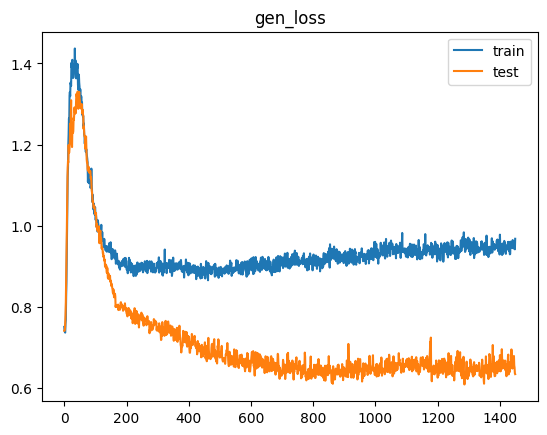

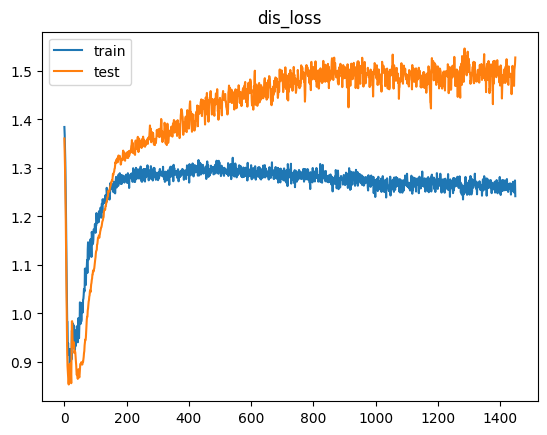

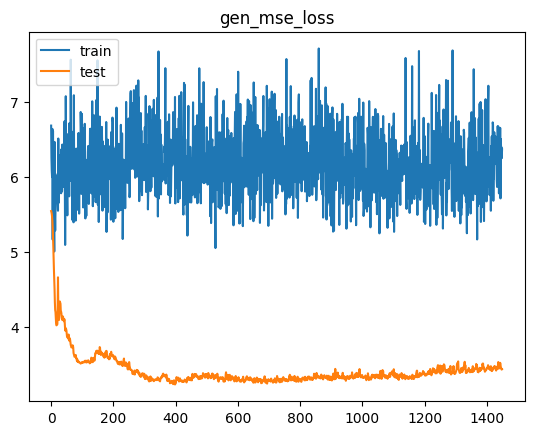

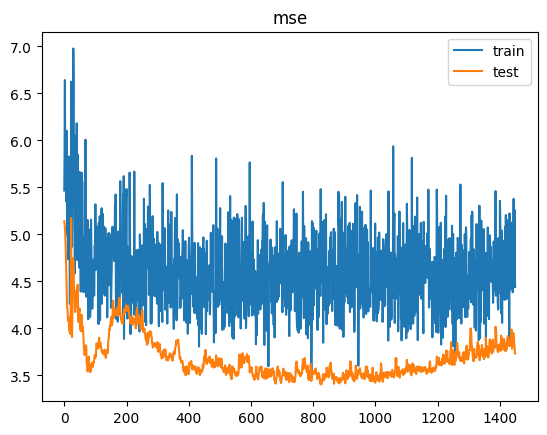

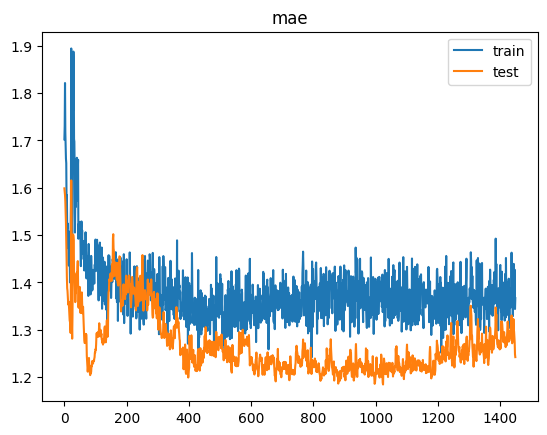

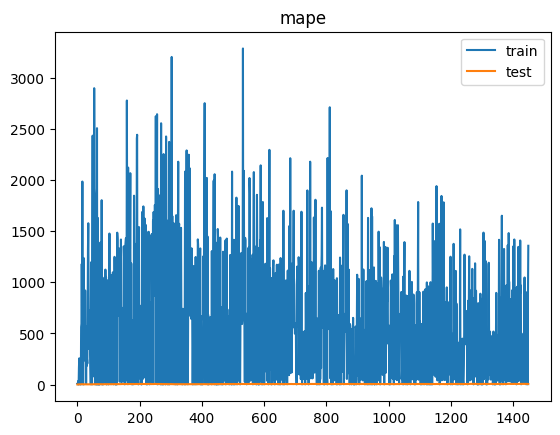

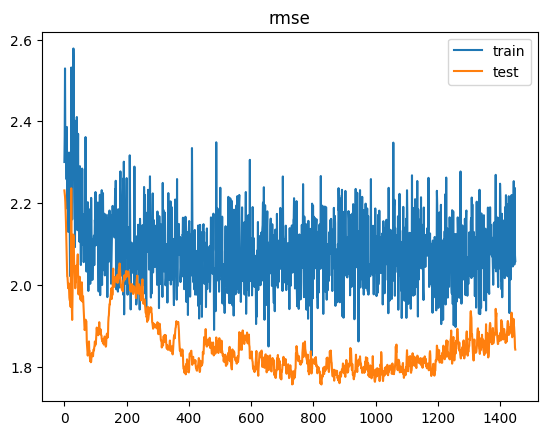

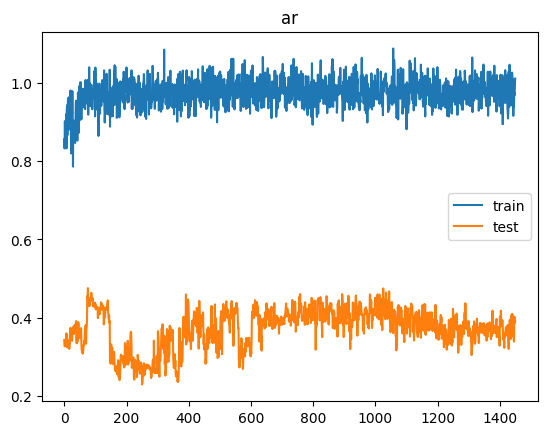

2/2 [==============================] - 0s 4ms/step


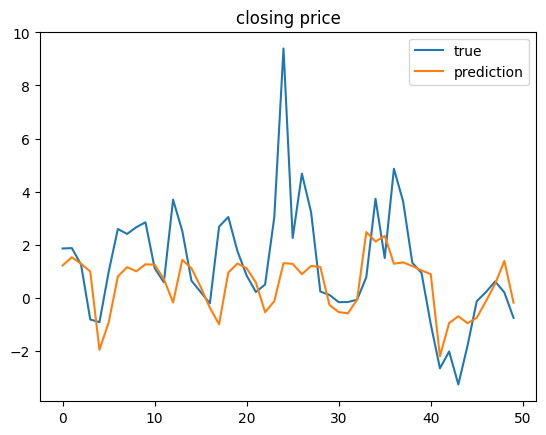

[MSE Baseline] train: 4.676425753662662  test: 3.665913330963867
Delta time with epochs = 1450: 0:12:15.724783


In [21]:
for epochs in [950, 1200, 1450]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("gru_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_12 (GRU)                (None, 5, 10)             570       
                                                                 
 batch_normalization_12 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_30 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_13 (GRU)                (None, 10)                660       
                                                           

Time for epoch 53 is 0.5286650657653809 sec Generator Loss: 1.3638837337493896,  Discriminator_loss: 0.9692341089248657
Time for epoch 54 is 0.5486807823181152 sec Generator Loss: 1.4126750230789185,  Discriminator_loss: 0.9577439427375793
Time for epoch 55 is 0.5335767269134521 sec Generator Loss: 1.3852922916412354,  Discriminator_loss: 0.9835357666015625
Time for epoch 56 is 0.5192403793334961 sec Generator Loss: 1.3138585090637207,  Discriminator_loss: 0.9934219717979431
Time for epoch 57 is 0.536529541015625 sec Generator Loss: 1.3639633655548096,  Discriminator_loss: 0.993766725063324
Time for epoch 58 is 0.5041930675506592 sec Generator Loss: 1.339476227760315,  Discriminator_loss: 0.9944917559623718
Time for epoch 59 is 0.5093309879302979 sec Generator Loss: 1.3270244598388672,  Discriminator_loss: 1.0000399351119995
Time for epoch 60 is 0.49155116081237793 sec Generator Loss: 1.3209240436553955,  Discriminator_loss: 1.0018930435180664
Time for epoch 61 is 0.514340877532959 sec

Time for epoch 122 is 0.5536379814147949 sec Generator Loss: 0.9758908748626709,  Discriminator_loss: 1.2306442260742188
Time for epoch 123 is 0.5370829105377197 sec Generator Loss: 0.996797502040863,  Discriminator_loss: 1.2145748138427734
Time for epoch 124 is 0.542949914932251 sec Generator Loss: 0.9674193263053894,  Discriminator_loss: 1.252708077430725
Time for epoch 125 is 0.6321358680725098 sec Generator Loss: 0.979465663433075,  Discriminator_loss: 1.2232997417449951
Time for epoch 126 is 0.5227744579315186 sec Generator Loss: 0.9730803370475769,  Discriminator_loss: 1.2360721826553345
Time for epoch 127 is 0.4980754852294922 sec Generator Loss: 0.9654263257980347,  Discriminator_loss: 1.2380551099777222
Time for epoch 128 is 0.47885990142822266 sec Generator Loss: 0.9559706449508667,  Discriminator_loss: 1.2575212717056274
Time for epoch 129 is 0.501838207244873 sec Generator Loss: 0.9704462289810181,  Discriminator_loss: 1.2282625436782837
Time for epoch 130 is 0.473260164260

Time for epoch 190 is 0.47824764251708984 sec Generator Loss: 0.917722225189209,  Discriminator_loss: 1.2675338983535767
Time for epoch 191 is 0.4633450508117676 sec Generator Loss: 0.9385198950767517,  Discriminator_loss: 1.2705823183059692
Time for epoch 192 is 0.4638671875 sec Generator Loss: 0.9250147938728333,  Discriminator_loss: 1.2571700811386108
Time for epoch 193 is 0.474729061126709 sec Generator Loss: 0.9214871525764465,  Discriminator_loss: 1.2548054456710815
Time for epoch 194 is 0.4623684883117676 sec Generator Loss: 0.9133405089378357,  Discriminator_loss: 1.2591335773468018
Time for epoch 195 is 0.469559907913208 sec Generator Loss: 0.9191133975982666,  Discriminator_loss: 1.2738527059555054
Time for epoch 196 is 0.4682958126068115 sec Generator Loss: 0.9245613217353821,  Discriminator_loss: 1.2664587497711182
Time for epoch 197 is 0.4748830795288086 sec Generator Loss: 0.9079832434654236,  Discriminator_loss: 1.2811615467071533
Time for epoch 198 is 0.5113575458526611

Time for epoch 258 is 0.4703209400177002 sec Generator Loss: 0.9077956676483154,  Discriminator_loss: 1.2616653442382812
Time for epoch 259 is 0.46074938774108887 sec Generator Loss: 0.9177961349487305,  Discriminator_loss: 1.2730687856674194
Time for epoch 260 is 0.49916672706604004 sec Generator Loss: 0.9137238264083862,  Discriminator_loss: 1.2678906917572021
Time for epoch 261 is 0.4814791679382324 sec Generator Loss: 0.9106521606445312,  Discriminator_loss: 1.2727771997451782
Time for epoch 262 is 0.4781224727630615 sec Generator Loss: 0.9240680932998657,  Discriminator_loss: 1.2663569450378418
Time for epoch 263 is 0.4787557125091553 sec Generator Loss: 0.9067166447639465,  Discriminator_loss: 1.2720015048980713
Time for epoch 264 is 0.4618563652038574 sec Generator Loss: 0.900887131690979,  Discriminator_loss: 1.276001214981079
Time for epoch 265 is 0.6002848148345947 sec Generator Loss: 0.9049264192581177,  Discriminator_loss: 1.2823249101638794
Time for epoch 266 is 0.49055957

Time for epoch 326 is 0.4688537120819092 sec Generator Loss: 0.9101735353469849,  Discriminator_loss: 1.2745113372802734
Time for epoch 327 is 0.4994008541107178 sec Generator Loss: 0.9067555665969849,  Discriminator_loss: 1.272704005241394
Time for epoch 328 is 0.5151345729827881 sec Generator Loss: 0.9027660489082336,  Discriminator_loss: 1.282773733139038
Time for epoch 329 is 0.4672701358795166 sec Generator Loss: 0.8988139033317566,  Discriminator_loss: 1.2793654203414917
Time for epoch 330 is 0.4915354251861572 sec Generator Loss: 0.9010345935821533,  Discriminator_loss: 1.277987003326416
Time for epoch 331 is 2.468920946121216 sec Generator Loss: 0.9188565611839294,  Discriminator_loss: 1.2645646333694458
Time for epoch 332 is 0.5219326019287109 sec Generator Loss: 0.9142369627952576,  Discriminator_loss: 1.2760745286941528
Time for epoch 333 is 0.5095176696777344 sec Generator Loss: 0.9082713723182678,  Discriminator_loss: 1.2686448097229004
Time for epoch 334 is 0.471315622329

Time for epoch 394 is 0.4833545684814453 sec Generator Loss: 0.9088560342788696,  Discriminator_loss: 1.2846318483352661
Time for epoch 395 is 0.49260687828063965 sec Generator Loss: 0.9021310806274414,  Discriminator_loss: 1.2778359651565552
Time for epoch 396 is 0.513714075088501 sec Generator Loss: 0.8888127207756042,  Discriminator_loss: 1.2874675989151
Time for epoch 397 is 0.5084731578826904 sec Generator Loss: 0.8924210071563721,  Discriminator_loss: 1.276261329650879
Time for epoch 398 is 0.470531702041626 sec Generator Loss: 0.9033000469207764,  Discriminator_loss: 1.2747650146484375
Time for epoch 399 is 0.4882700443267822 sec Generator Loss: 0.8979679346084595,  Discriminator_loss: 1.2803382873535156
Time for epoch 400 is 0.46791863441467285 sec Generator Loss: 0.9016878604888916,  Discriminator_loss: 1.2724499702453613
Time for epoch 401 is 0.47420597076416016 sec Generator Loss: 0.8994047045707703,  Discriminator_loss: 1.2725245952606201
Time for epoch 402 is 0.47410345077

Time for epoch 462 is 0.519019365310669 sec Generator Loss: 0.9115285873413086,  Discriminator_loss: 1.285767912864685
Time for epoch 463 is 0.5027406215667725 sec Generator Loss: 0.891975462436676,  Discriminator_loss: 1.289825439453125
Time for epoch 464 is 0.5426821708679199 sec Generator Loss: 0.91557776927948,  Discriminator_loss: 1.2700858116149902
Time for epoch 465 is 0.5127196311950684 sec Generator Loss: 0.9073781967163086,  Discriminator_loss: 1.2734160423278809
Time for epoch 466 is 0.5135238170623779 sec Generator Loss: 0.8916711807250977,  Discriminator_loss: 1.2983072996139526
Time for epoch 467 is 0.5166893005371094 sec Generator Loss: 0.9094684720039368,  Discriminator_loss: 1.2740644216537476
Time for epoch 468 is 0.5011365413665771 sec Generator Loss: 0.9031638503074646,  Discriminator_loss: 1.2906157970428467
Time for epoch 469 is 0.5722932815551758 sec Generator Loss: 0.9126242399215698,  Discriminator_loss: 1.2703930139541626
Time for epoch 470 is 0.55677056312561

Time for epoch 530 is 0.5697202682495117 sec Generator Loss: 0.9285560846328735,  Discriminator_loss: 1.2657121419906616
Time for epoch 531 is 0.5528507232666016 sec Generator Loss: 0.9174248576164246,  Discriminator_loss: 1.255751132965088
Time for epoch 532 is 0.5124356746673584 sec Generator Loss: 0.8887594938278198,  Discriminator_loss: 1.2819119691848755
Time for epoch 533 is 0.5056824684143066 sec Generator Loss: 0.9051036238670349,  Discriminator_loss: 1.2916148900985718
Time for epoch 534 is 0.5293467044830322 sec Generator Loss: 0.9185812473297119,  Discriminator_loss: 1.2686046361923218
Time for epoch 535 is 0.5613932609558105 sec Generator Loss: 0.9351884722709656,  Discriminator_loss: 1.2837501764297485
Time for epoch 536 is 0.4913330078125 sec Generator Loss: 0.917222797870636,  Discriminator_loss: 1.2745763063430786
Time for epoch 537 is 0.5829946994781494 sec Generator Loss: 0.9023306965827942,  Discriminator_loss: 1.288940668106079
Time for epoch 538 is 0.59372830390930

Time for epoch 598 is 0.6659224033355713 sec Generator Loss: 0.9224313497543335,  Discriminator_loss: 1.255070686340332
Time for epoch 599 is 0.528592586517334 sec Generator Loss: 0.9170475006103516,  Discriminator_loss: 1.2710717916488647
Time for epoch 600 is 0.5460391044616699 sec Generator Loss: 0.9362277984619141,  Discriminator_loss: 1.254528284072876
Time for epoch 601 is 0.5300357341766357 sec Generator Loss: 0.92193603515625,  Discriminator_loss: 1.2681313753128052
Time for epoch 602 is 0.5350470542907715 sec Generator Loss: 0.9207137823104858,  Discriminator_loss: 1.2581307888031006
Time for epoch 603 is 0.4948539733886719 sec Generator Loss: 0.9252749681472778,  Discriminator_loss: 1.258516788482666
Time for epoch 604 is 0.4949328899383545 sec Generator Loss: 0.9117400646209717,  Discriminator_loss: 1.2695032358169556
Time for epoch 605 is 0.5542590618133545 sec Generator Loss: 0.9211592078208923,  Discriminator_loss: 1.2499397993087769
Time for epoch 606 is 0.79729104042053

Time for epoch 666 is 0.4945507049560547 sec Generator Loss: 0.9268774390220642,  Discriminator_loss: 1.2600836753845215
Time for epoch 667 is 0.4697756767272949 sec Generator Loss: 0.9304161667823792,  Discriminator_loss: 1.2486008405685425
Time for epoch 668 is 0.49028921127319336 sec Generator Loss: 0.94058758020401,  Discriminator_loss: 1.2504104375839233
Time for epoch 669 is 0.4721693992614746 sec Generator Loss: 0.9277917742729187,  Discriminator_loss: 1.266024112701416
Time for epoch 670 is 0.4678823947906494 sec Generator Loss: 0.9291009902954102,  Discriminator_loss: 1.2589404582977295
Time for epoch 671 is 0.477339506149292 sec Generator Loss: 0.9265788197517395,  Discriminator_loss: 1.2751959562301636
Time for epoch 672 is 0.4782743453979492 sec Generator Loss: 0.9173709750175476,  Discriminator_loss: 1.2739555835723877
Time for epoch 673 is 0.4769470691680908 sec Generator Loss: 0.9368832111358643,  Discriminator_loss: 1.2598876953125
Time for epoch 674 is 0.47647261619567

Time for epoch 734 is 0.5077431201934814 sec Generator Loss: 0.9351244568824768,  Discriminator_loss: 1.2571355104446411
Time for epoch 735 is 0.4982454776763916 sec Generator Loss: 0.9230564832687378,  Discriminator_loss: 1.2660455703735352
Time for epoch 736 is 0.5038418769836426 sec Generator Loss: 0.9184036254882812,  Discriminator_loss: 1.2645527124404907
Time for epoch 737 is 0.4812002182006836 sec Generator Loss: 0.9336779117584229,  Discriminator_loss: 1.2494513988494873
Time for epoch 738 is 0.4890401363372803 sec Generator Loss: 0.9323380589485168,  Discriminator_loss: 1.2640694379806519
Time for epoch 739 is 0.4964277744293213 sec Generator Loss: 0.9346858263015747,  Discriminator_loss: 1.2570033073425293
Time for epoch 740 is 0.47063350677490234 sec Generator Loss: 0.9230651259422302,  Discriminator_loss: 1.2608481645584106
Time for epoch 741 is 0.4872455596923828 sec Generator Loss: 0.9473699331283569,  Discriminator_loss: 1.2368874549865723
Time for epoch 742 is 0.4734513

Time for epoch 802 is 0.6794672012329102 sec Generator Loss: 0.9543638825416565,  Discriminator_loss: 1.24515700340271
Time for epoch 803 is 0.6206486225128174 sec Generator Loss: 0.9467581510543823,  Discriminator_loss: 1.255115032196045
Time for epoch 804 is 0.6171505451202393 sec Generator Loss: 0.9544283747673035,  Discriminator_loss: 1.234811782836914
Time for epoch 805 is 0.5831174850463867 sec Generator Loss: 0.9501228332519531,  Discriminator_loss: 1.2432191371917725
Time for epoch 806 is 0.5775101184844971 sec Generator Loss: 0.9636459350585938,  Discriminator_loss: 1.2339928150177002
Time for epoch 807 is 0.565943717956543 sec Generator Loss: 0.9501813650131226,  Discriminator_loss: 1.2435204982757568
Time for epoch 808 is 0.5753879547119141 sec Generator Loss: 0.9384884834289551,  Discriminator_loss: 1.2685619592666626
Time for epoch 809 is 0.6056532859802246 sec Generator Loss: 0.9570064544677734,  Discriminator_loss: 1.2469758987426758
Time for epoch 810 is 0.5272655487060

Time for epoch 870 is 0.5384275913238525 sec Generator Loss: 0.9441023468971252,  Discriminator_loss: 1.2559900283813477
Time for epoch 871 is 0.5457484722137451 sec Generator Loss: 0.9507851600646973,  Discriminator_loss: 1.2534395456314087
Time for epoch 872 is 0.5343506336212158 sec Generator Loss: 0.957245409488678,  Discriminator_loss: 1.2558783292770386
Time for epoch 873 is 0.5533456802368164 sec Generator Loss: 0.9602603912353516,  Discriminator_loss: 1.2471511363983154
Time for epoch 874 is 0.5504193305969238 sec Generator Loss: 0.9382804036140442,  Discriminator_loss: 1.248671054840088
Time for epoch 875 is 0.5205066204071045 sec Generator Loss: 0.9269553422927856,  Discriminator_loss: 1.252036452293396
Time for epoch 876 is 0.5270419120788574 sec Generator Loss: 0.9486321806907654,  Discriminator_loss: 1.254775047302246
Time for epoch 877 is 0.5269877910614014 sec Generator Loss: 0.9608129262924194,  Discriminator_loss: 1.2457674741744995
Time for epoch 878 is 0.520394563674

Time for epoch 938 is 0.523688793182373 sec Generator Loss: 0.9703269600868225,  Discriminator_loss: 1.2320983409881592
Time for epoch 939 is 0.5335245132446289 sec Generator Loss: 0.9494968056678772,  Discriminator_loss: 1.262258768081665
Time for epoch 940 is 0.5211291313171387 sec Generator Loss: 0.9420273900032043,  Discriminator_loss: 1.270334243774414
Time for epoch 941 is 0.5227329730987549 sec Generator Loss: 0.9287475347518921,  Discriminator_loss: 1.2587300539016724
Time for epoch 942 is 0.5311214923858643 sec Generator Loss: 0.9635226130485535,  Discriminator_loss: 1.2364156246185303
Time for epoch 943 is 0.5409936904907227 sec Generator Loss: 0.9615447521209717,  Discriminator_loss: 1.2532474994659424
Time for epoch 944 is 0.5556974411010742 sec Generator Loss: 0.9335939288139343,  Discriminator_loss: 1.2544482946395874
Time for epoch 945 is 0.5314788818359375 sec Generator Loss: 0.9442142844200134,  Discriminator_loss: 1.2544164657592773
Time for epoch 946 is 0.52381253242

Time for epoch 1006 is 0.5764262676239014 sec Generator Loss: 0.9854484796524048,  Discriminator_loss: 1.226581335067749
Time for epoch 1007 is 0.6150259971618652 sec Generator Loss: 0.9679986834526062,  Discriminator_loss: 1.2349165678024292
Time for epoch 1008 is 0.5853903293609619 sec Generator Loss: 0.9468691349029541,  Discriminator_loss: 1.2490818500518799
Time for epoch 1009 is 0.5871436595916748 sec Generator Loss: 0.9408400654792786,  Discriminator_loss: 1.2709591388702393
Time for epoch 1010 is 0.593717098236084 sec Generator Loss: 0.959648609161377,  Discriminator_loss: 1.2485400438308716
Time for epoch 1011 is 0.5606005191802979 sec Generator Loss: 0.95598304271698,  Discriminator_loss: 1.254882574081421
Time for epoch 1012 is 0.5775384902954102 sec Generator Loss: 0.9451769590377808,  Discriminator_loss: 1.2607096433639526
Time for epoch 1013 is 0.5758757591247559 sec Generator Loss: 0.9478990435600281,  Discriminator_loss: 1.2539525032043457
Time for epoch 1014 is 0.59482

Time for epoch 1074 is 0.5401437282562256 sec Generator Loss: 0.9524965286254883,  Discriminator_loss: 1.2499433755874634
Time for epoch 1075 is 0.53255295753479 sec Generator Loss: 0.9593738913536072,  Discriminator_loss: 1.2452027797698975
Time for epoch 1076 is 0.5218088626861572 sec Generator Loss: 0.9606136083602905,  Discriminator_loss: 1.255583643913269
Time for epoch 1077 is 0.5543415546417236 sec Generator Loss: 0.9435036182403564,  Discriminator_loss: 1.2482990026474
Time for epoch 1078 is 0.5230958461761475 sec Generator Loss: 0.9560616612434387,  Discriminator_loss: 1.2533830404281616
Time for epoch 1079 is 0.5346918106079102 sec Generator Loss: 0.9586712718009949,  Discriminator_loss: 1.2433531284332275
Time for epoch 1080 is 0.5029652118682861 sec Generator Loss: 0.9504168629646301,  Discriminator_loss: 1.2338732481002808
Time for epoch 1081 is 0.5523810386657715 sec Generator Loss: 0.9688214659690857,  Discriminator_loss: 1.251697301864624
Time for epoch 1082 is 0.540994

Time for epoch 1142 is 0.7059605121612549 sec Generator Loss: 0.9802675247192383,  Discriminator_loss: 1.2233465909957886
Time for epoch 1143 is 0.6456365585327148 sec Generator Loss: 0.9795835614204407,  Discriminator_loss: 1.2372777462005615
Time for epoch 1144 is 0.6906883716583252 sec Generator Loss: 0.9706919193267822,  Discriminator_loss: 1.2415653467178345
Time for epoch 1145 is 0.6721632480621338 sec Generator Loss: 0.957301914691925,  Discriminator_loss: 1.2445863485336304
Time for epoch 1146 is 0.6285734176635742 sec Generator Loss: 0.9663898944854736,  Discriminator_loss: 1.2208304405212402
Time for epoch 1147 is 0.7059135437011719 sec Generator Loss: 0.9748823046684265,  Discriminator_loss: 1.2204092741012573
Time for epoch 1148 is 0.6586134433746338 sec Generator Loss: 0.9941873550415039,  Discriminator_loss: 1.230073094367981
Time for epoch 1149 is 0.6158349514007568 sec Generator Loss: 0.9727197885513306,  Discriminator_loss: 1.2373379468917847
Time for epoch 1150 is 0.6

Time for epoch 1210 is 0.48981451988220215 sec Generator Loss: 0.9732947945594788,  Discriminator_loss: 1.2131621837615967
Time for epoch 1211 is 0.48621439933776855 sec Generator Loss: 0.9689262509346008,  Discriminator_loss: 1.2427810430526733
Time for epoch 1212 is 0.5003345012664795 sec Generator Loss: 0.9558331966400146,  Discriminator_loss: 1.2341123819351196
Time for epoch 1213 is 0.5044989585876465 sec Generator Loss: 0.9672780632972717,  Discriminator_loss: 1.2482541799545288
Time for epoch 1214 is 0.5215086936950684 sec Generator Loss: 0.9699461460113525,  Discriminator_loss: 1.239353895187378
Time for epoch 1215 is 0.5175924301147461 sec Generator Loss: 0.9627578854560852,  Discriminator_loss: 1.2538918256759644
Time for epoch 1216 is 0.6544373035430908 sec Generator Loss: 0.983510434627533,  Discriminator_loss: 1.2061823606491089
Time for epoch 1217 is 0.5262875556945801 sec Generator Loss: 0.9467137455940247,  Discriminator_loss: 1.2529404163360596
Time for epoch 1218 is 0

Time for epoch 1278 is 0.6349637508392334 sec Generator Loss: 0.9815917015075684,  Discriminator_loss: 1.2398877143859863
Time for epoch 1279 is 0.5376179218292236 sec Generator Loss: 0.9570828080177307,  Discriminator_loss: 1.2629473209381104
Time for epoch 1280 is 0.5475938320159912 sec Generator Loss: 0.9657223224639893,  Discriminator_loss: 1.2367699146270752
Time for epoch 1281 is 0.48826146125793457 sec Generator Loss: 0.9566043019294739,  Discriminator_loss: 1.2536046504974365
Time for epoch 1282 is 0.5069618225097656 sec Generator Loss: 0.9564549326896667,  Discriminator_loss: 1.2468987703323364
Time for epoch 1283 is 0.5025887489318848 sec Generator Loss: 0.9573872685432434,  Discriminator_loss: 1.2502970695495605
Time for epoch 1284 is 0.5049476623535156 sec Generator Loss: 0.9474470019340515,  Discriminator_loss: 1.242428183555603
Time for epoch 1285 is 0.4696953296661377 sec Generator Loss: 0.9505197405815125,  Discriminator_loss: 1.2458645105361938
Time for epoch 1286 is 0

Time for epoch 1346 is 0.5456380844116211 sec Generator Loss: 0.9511826634407043,  Discriminator_loss: 1.2437552213668823
Time for epoch 1347 is 0.6033768653869629 sec Generator Loss: 0.9714232683181763,  Discriminator_loss: 1.2325398921966553
Time for epoch 1348 is 0.5160613059997559 sec Generator Loss: 0.9641942977905273,  Discriminator_loss: 1.2442822456359863
Time for epoch 1349 is 0.5169525146484375 sec Generator Loss: 0.9786040186882019,  Discriminator_loss: 1.238843560218811
Time for epoch 1350 is 0.5049276351928711 sec Generator Loss: 0.9849568605422974,  Discriminator_loss: 1.2341771125793457
Time for epoch 1351 is 0.5372211933135986 sec Generator Loss: 0.9671746492385864,  Discriminator_loss: 1.2450523376464844
Time for epoch 1352 is 0.5563101768493652 sec Generator Loss: 0.9626114368438721,  Discriminator_loss: 1.2441178560256958
Time for epoch 1353 is 0.6172888278961182 sec Generator Loss: 0.9691228866577148,  Discriminator_loss: 1.2423417568206787
Time for epoch 1354 is 0.

Time for epoch 1414 is 0.46853137016296387 sec Generator Loss: 0.9665249586105347,  Discriminator_loss: 1.240442156791687
Time for epoch 1415 is 0.46953344345092773 sec Generator Loss: 0.948950469493866,  Discriminator_loss: 1.2516403198242188
Time for epoch 1416 is 0.4725513458251953 sec Generator Loss: 0.9610889554023743,  Discriminator_loss: 1.2648495435714722
Time for epoch 1417 is 0.4634091854095459 sec Generator Loss: 0.9889220595359802,  Discriminator_loss: 1.2359334230422974
Time for epoch 1418 is 0.534005880355835 sec Generator Loss: 0.9537196159362793,  Discriminator_loss: 1.2610665559768677
Time for epoch 1419 is 0.46704673767089844 sec Generator Loss: 0.9553570747375488,  Discriminator_loss: 1.253238320350647
Time for epoch 1420 is 0.483518123626709 sec Generator Loss: 0.9570624828338623,  Discriminator_loss: 1.236807942390442
Time for epoch 1421 is 0.4660358428955078 sec Generator Loss: 0.9576427340507507,  Discriminator_loss: 1.246321439743042
Time for epoch 1422 is 0.471

Time for epoch 1482 is 0.5238256454467773 sec Generator Loss: 0.9531650543212891,  Discriminator_loss: 1.2476634979248047
Time for epoch 1483 is 0.5001604557037354 sec Generator Loss: 0.9490951895713806,  Discriminator_loss: 1.2489089965820312
Time for epoch 1484 is 0.478884220123291 sec Generator Loss: 0.9682192802429199,  Discriminator_loss: 1.233945369720459
Time for epoch 1485 is 0.4761824607849121 sec Generator Loss: 0.9721869230270386,  Discriminator_loss: 1.226419448852539
Time for epoch 1486 is 0.49388980865478516 sec Generator Loss: 0.9600157141685486,  Discriminator_loss: 1.2566865682601929
Time for epoch 1487 is 0.5058724880218506 sec Generator Loss: 0.9601126909255981,  Discriminator_loss: 1.2565995454788208
Time for epoch 1488 is 0.49661755561828613 sec Generator Loss: 0.9529122114181519,  Discriminator_loss: 1.2491250038146973
Time for epoch 1489 is 0.5182516574859619 sec Generator Loss: 0.9724336266517639,  Discriminator_loss: 1.2521977424621582
Time for epoch 1490 is 0.

Time for epoch 1550 is 0.4985508918762207 sec Generator Loss: 0.9554917812347412,  Discriminator_loss: 1.2509019374847412
Time for epoch 1551 is 0.4882326126098633 sec Generator Loss: 0.9791014790534973,  Discriminator_loss: 1.2458231449127197
Time for epoch 1552 is 0.4689218997955322 sec Generator Loss: 0.9692103862762451,  Discriminator_loss: 1.2545037269592285
Time for epoch 1553 is 0.4767897129058838 sec Generator Loss: 0.9593843221664429,  Discriminator_loss: 1.2461626529693604
Time for epoch 1554 is 0.49040985107421875 sec Generator Loss: 0.939963161945343,  Discriminator_loss: 1.246505856513977
Time for epoch 1555 is 0.4634735584259033 sec Generator Loss: 0.9674955606460571,  Discriminator_loss: 1.2562716007232666
Time for epoch 1556 is 0.5139243602752686 sec Generator Loss: 0.9400785565376282,  Discriminator_loss: 1.274057388305664
Time for epoch 1557 is 0.47182774543762207 sec Generator Loss: 0.9349951148033142,  Discriminator_loss: 1.2642085552215576
Time for epoch 1558 is 0.

Time for epoch 1618 is 0.4847238063812256 sec Generator Loss: 0.9622730016708374,  Discriminator_loss: 1.2586524486541748
Time for epoch 1619 is 0.4841132164001465 sec Generator Loss: 0.951484203338623,  Discriminator_loss: 1.2619175910949707
Time for epoch 1620 is 0.47170400619506836 sec Generator Loss: 0.9656242728233337,  Discriminator_loss: 1.247477650642395
Time for epoch 1621 is 0.4903523921966553 sec Generator Loss: 0.9542895555496216,  Discriminator_loss: 1.2501991987228394
Time for epoch 1622 is 0.46820998191833496 sec Generator Loss: 0.9628692269325256,  Discriminator_loss: 1.248788595199585
Time for epoch 1623 is 0.4965386390686035 sec Generator Loss: 0.9543974995613098,  Discriminator_loss: 1.256709098815918
Time for epoch 1624 is 0.47124457359313965 sec Generator Loss: 0.9635413885116577,  Discriminator_loss: 1.2460007667541504
Time for epoch 1625 is 0.4585235118865967 sec Generator Loss: 0.9674915671348572,  Discriminator_loss: 1.23916757106781
Time for epoch 1626 is 0.48

Time for epoch 1686 is 0.4658365249633789 sec Generator Loss: 0.949653685092926,  Discriminator_loss: 1.2618786096572876
Time for epoch 1687 is 0.4609189033508301 sec Generator Loss: 0.9740553498268127,  Discriminator_loss: 1.2342966794967651
Time for epoch 1688 is 0.4652714729309082 sec Generator Loss: 0.9707032442092896,  Discriminator_loss: 1.2373911142349243
Time for epoch 1689 is 0.441272497177124 sec Generator Loss: 0.9672856330871582,  Discriminator_loss: 1.249061942100525
Time for epoch 1690 is 0.46224522590637207 sec Generator Loss: 0.963064968585968,  Discriminator_loss: 1.2494142055511475
Time for epoch 1691 is 0.45621705055236816 sec Generator Loss: 0.9658399820327759,  Discriminator_loss: 1.2474632263183594
Time for epoch 1692 is 0.4745323657989502 sec Generator Loss: 0.9462858438491821,  Discriminator_loss: 1.2787147760391235
Time for epoch 1693 is 0.484691858291626 sec Generator Loss: 0.9401870369911194,  Discriminator_loss: 1.2557775974273682
Time for epoch 1694 is 0.49

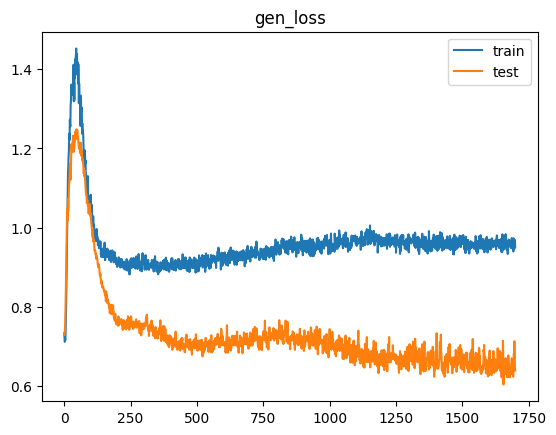

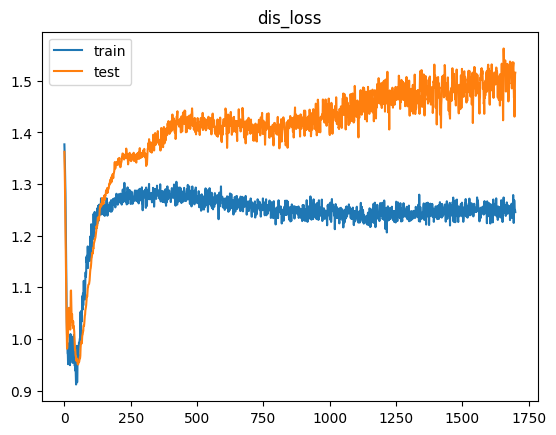

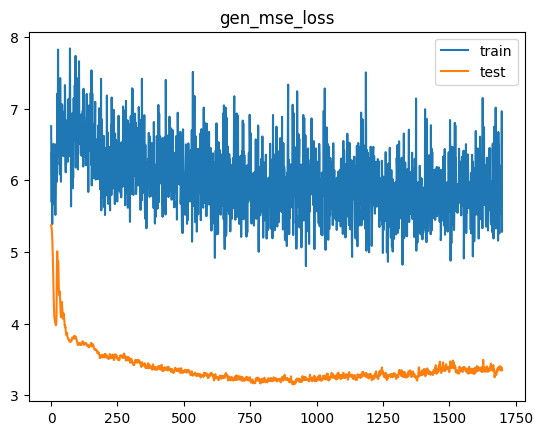

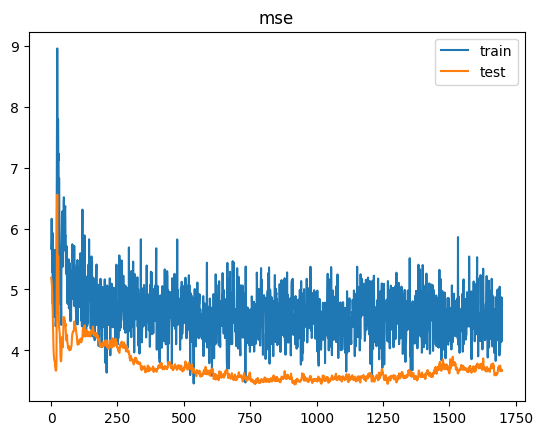

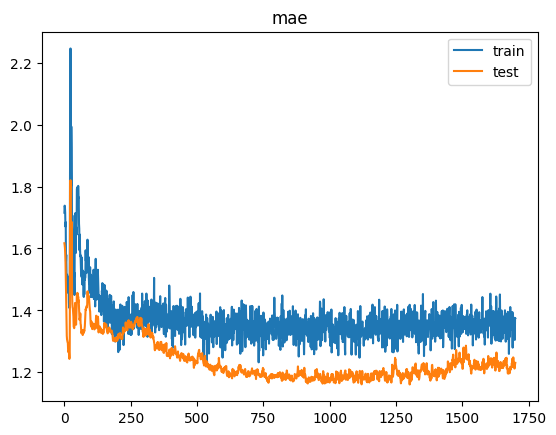

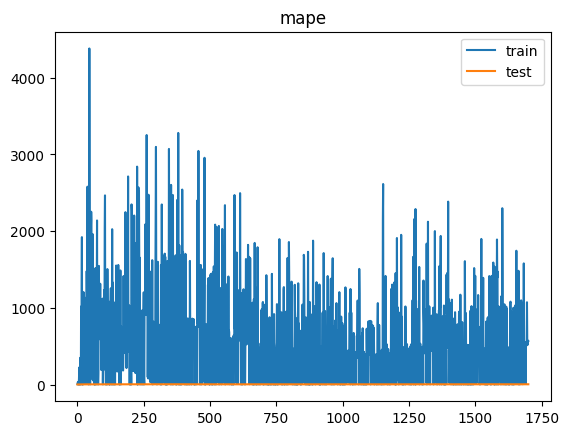

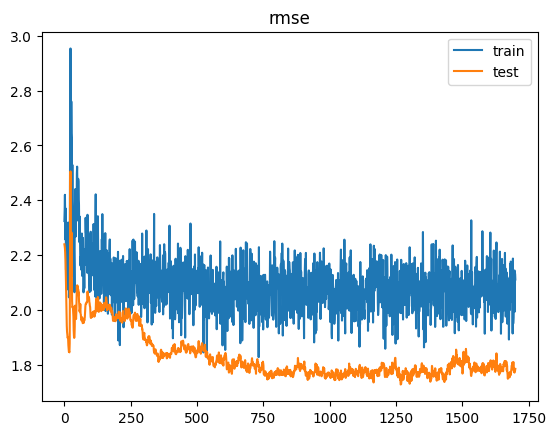

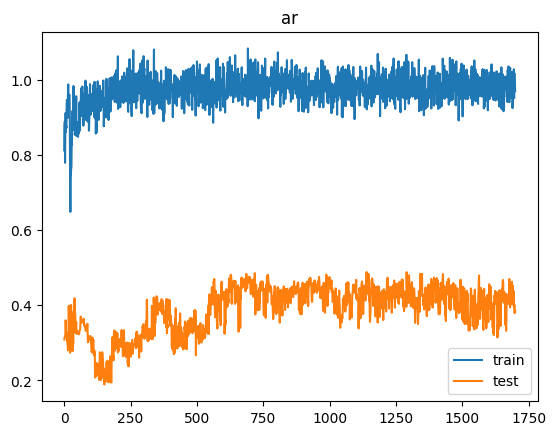

2/2 [==============================] - 0s 3ms/step


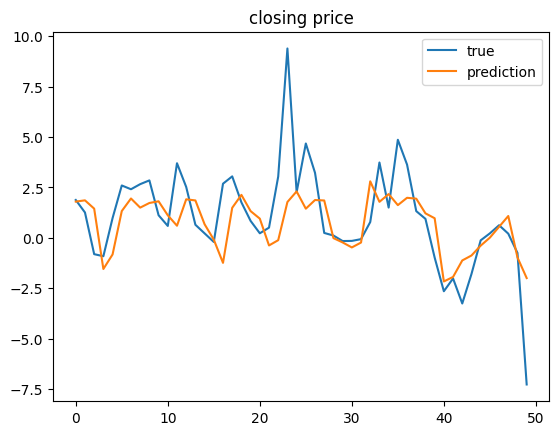

[MSE Baseline] train: 4.45189062703782  test: 3.634052838095099
Delta time with epochs = 1700: 0:15:11.523985
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_14 (GRU)                (None, 5, 10)             570       
                                                                 
 batch_normalization_14 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_35 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_15 (GRU)  

Time for epoch 52 is 0.4877054691314697 sec Generator Loss: 1.4608360528945923,  Discriminator_loss: 0.9707225561141968
Time for epoch 53 is 0.4710872173309326 sec Generator Loss: 1.3894298076629639,  Discriminator_loss: 0.9862619042396545
Time for epoch 54 is 0.4888923168182373 sec Generator Loss: 1.402169942855835,  Discriminator_loss: 0.9701128602027893
Time for epoch 55 is 0.46738719940185547 sec Generator Loss: 1.3863919973373413,  Discriminator_loss: 0.9817021489143372
Time for epoch 56 is 0.4978477954864502 sec Generator Loss: 1.4197804927825928,  Discriminator_loss: 0.9692103266716003
Time for epoch 57 is 0.4806678295135498 sec Generator Loss: 1.4181890487670898,  Discriminator_loss: 0.9814141392707825
Time for epoch 58 is 0.47629880905151367 sec Generator Loss: 1.3588359355926514,  Discriminator_loss: 1.0217058658599854
Time for epoch 59 is 0.4720604419708252 sec Generator Loss: 1.3934099674224854,  Discriminator_loss: 1.0028300285339355
Time for epoch 60 is 0.4685218334197998

Time for epoch 121 is 0.507521390914917 sec Generator Loss: 1.0008708238601685,  Discriminator_loss: 1.1856988668441772
Time for epoch 122 is 0.5530357360839844 sec Generator Loss: 0.9938911199569702,  Discriminator_loss: 1.2056399583816528
Time for epoch 123 is 0.4918053150177002 sec Generator Loss: 1.0034886598587036,  Discriminator_loss: 1.1965452432632446
Time for epoch 124 is 0.47225332260131836 sec Generator Loss: 0.9766286611557007,  Discriminator_loss: 1.2192535400390625
Time for epoch 125 is 0.4937424659729004 sec Generator Loss: 0.9766324758529663,  Discriminator_loss: 1.2076609134674072
Time for epoch 126 is 0.497875452041626 sec Generator Loss: 0.9920317530632019,  Discriminator_loss: 1.1998555660247803
Time for epoch 127 is 0.4726569652557373 sec Generator Loss: 0.9775786995887756,  Discriminator_loss: 1.2209194898605347
Time for epoch 128 is 0.4839630126953125 sec Generator Loss: 0.968650758266449,  Discriminator_loss: 1.2244250774383545
Time for epoch 129 is 0.4716210365

Time for epoch 189 is 0.5052099227905273 sec Generator Loss: 0.9100400805473328,  Discriminator_loss: 1.2691600322723389
Time for epoch 190 is 0.49364471435546875 sec Generator Loss: 0.9104723334312439,  Discriminator_loss: 1.2717400789260864
Time for epoch 191 is 0.4898667335510254 sec Generator Loss: 0.9287660717964172,  Discriminator_loss: 1.2628134489059448
Time for epoch 192 is 0.5014786720275879 sec Generator Loss: 0.9138590693473816,  Discriminator_loss: 1.2632830142974854
Time for epoch 193 is 0.5126073360443115 sec Generator Loss: 0.9378446340560913,  Discriminator_loss: 1.2475605010986328
Time for epoch 194 is 0.4754972457885742 sec Generator Loss: 0.9226856827735901,  Discriminator_loss: 1.259030818939209
Time for epoch 195 is 0.47614240646362305 sec Generator Loss: 0.8940918445587158,  Discriminator_loss: 1.2781612873077393
Time for epoch 196 is 0.46192502975463867 sec Generator Loss: 0.904774010181427,  Discriminator_loss: 1.2787355184555054
Time for epoch 197 is 0.4752905

Time for epoch 257 is 0.5305225849151611 sec Generator Loss: 0.9289352893829346,  Discriminator_loss: 1.2511135339736938
Time for epoch 258 is 0.5607883930206299 sec Generator Loss: 0.9151627421379089,  Discriminator_loss: 1.2609156370162964
Time for epoch 259 is 0.5253274440765381 sec Generator Loss: 0.9031877517700195,  Discriminator_loss: 1.2752834558486938
Time for epoch 260 is 0.5189411640167236 sec Generator Loss: 0.9198347330093384,  Discriminator_loss: 1.2552491426467896
Time for epoch 261 is 0.47519445419311523 sec Generator Loss: 0.92348313331604,  Discriminator_loss: 1.2563438415527344
Time for epoch 262 is 0.47948741912841797 sec Generator Loss: 0.9235914945602417,  Discriminator_loss: 1.2623956203460693
Time for epoch 263 is 0.527437686920166 sec Generator Loss: 0.9085819125175476,  Discriminator_loss: 1.268291711807251
Time for epoch 264 is 0.4747488498687744 sec Generator Loss: 0.9159355163574219,  Discriminator_loss: 1.2613917589187622
Time for epoch 265 is 0.5316641330

Time for epoch 325 is 0.4781949520111084 sec Generator Loss: 0.9372855424880981,  Discriminator_loss: 1.2529783248901367
Time for epoch 326 is 0.47191858291625977 sec Generator Loss: 0.9076815843582153,  Discriminator_loss: 1.2668033838272095
Time for epoch 327 is 0.5092439651489258 sec Generator Loss: 0.8957333564758301,  Discriminator_loss: 1.268627405166626
Time for epoch 328 is 0.4799942970275879 sec Generator Loss: 0.9066611528396606,  Discriminator_loss: 1.2667382955551147
Time for epoch 329 is 0.5176758766174316 sec Generator Loss: 0.9029853343963623,  Discriminator_loss: 1.2778476476669312
Time for epoch 330 is 0.5644700527191162 sec Generator Loss: 0.9166439175605774,  Discriminator_loss: 1.252650499343872
Time for epoch 331 is 0.5002086162567139 sec Generator Loss: 0.9172953367233276,  Discriminator_loss: 1.2545126676559448
Time for epoch 332 is 0.4885365962982178 sec Generator Loss: 0.9129173755645752,  Discriminator_loss: 1.269956111907959
Time for epoch 333 is 0.6301193237

Time for epoch 393 is 0.5998373031616211 sec Generator Loss: 0.9260449409484863,  Discriminator_loss: 1.2582306861877441
Time for epoch 394 is 0.5612025260925293 sec Generator Loss: 0.9108584523200989,  Discriminator_loss: 1.276881456375122
Time for epoch 395 is 0.5541367530822754 sec Generator Loss: 0.895057737827301,  Discriminator_loss: 1.2816637754440308
Time for epoch 396 is 0.5929222106933594 sec Generator Loss: 0.9224764108657837,  Discriminator_loss: 1.2549285888671875
Time for epoch 397 is 0.5350852012634277 sec Generator Loss: 0.9189296960830688,  Discriminator_loss: 1.265831470489502
Time for epoch 398 is 0.5412070751190186 sec Generator Loss: 0.9026479125022888,  Discriminator_loss: 1.2753303050994873
Time for epoch 399 is 0.4924201965332031 sec Generator Loss: 0.924942672252655,  Discriminator_loss: 1.2693668603897095
Time for epoch 400 is 0.5132734775543213 sec Generator Loss: 0.9113110899925232,  Discriminator_loss: 1.2654845714569092
Time for epoch 401 is 0.487862110137

Time for epoch 462 is 0.6270294189453125 sec Generator Loss: 0.9147908091545105,  Discriminator_loss: 1.278997778892517
Time for epoch 463 is 0.617455244064331 sec Generator Loss: 0.9286901354789734,  Discriminator_loss: 1.2581720352172852
Time for epoch 464 is 0.5756876468658447 sec Generator Loss: 0.9046689867973328,  Discriminator_loss: 1.2706226110458374
Time for epoch 465 is 0.5257198810577393 sec Generator Loss: 0.9093866348266602,  Discriminator_loss: 1.269199252128601
Time for epoch 466 is 0.5121893882751465 sec Generator Loss: 0.9032198190689087,  Discriminator_loss: 1.2758491039276123
Time for epoch 467 is 0.49029994010925293 sec Generator Loss: 0.9227753281593323,  Discriminator_loss: 1.2682167291641235
Time for epoch 468 is 0.48848485946655273 sec Generator Loss: 0.9108284711837769,  Discriminator_loss: 1.272279977798462
Time for epoch 469 is 0.47595906257629395 sec Generator Loss: 0.9214183688163757,  Discriminator_loss: 1.2768217325210571
Time for epoch 470 is 0.486293554

Time for epoch 530 is 0.4795856475830078 sec Generator Loss: 0.9199213981628418,  Discriminator_loss: 1.265562891960144
Time for epoch 531 is 0.4778165817260742 sec Generator Loss: 0.9174057841300964,  Discriminator_loss: 1.263336181640625
Time for epoch 532 is 0.4937872886657715 sec Generator Loss: 0.929543673992157,  Discriminator_loss: 1.2707206010818481
Time for epoch 533 is 0.47055602073669434 sec Generator Loss: 0.918236494064331,  Discriminator_loss: 1.2813522815704346
Time for epoch 534 is 0.48027992248535156 sec Generator Loss: 0.9234033226966858,  Discriminator_loss: 1.2616277933120728
Time for epoch 535 is 0.542949914932251 sec Generator Loss: 0.9158654808998108,  Discriminator_loss: 1.2640305757522583
Time for epoch 536 is 0.4858250617980957 sec Generator Loss: 0.9021962881088257,  Discriminator_loss: 1.2881933450698853
Time for epoch 537 is 0.4898567199707031 sec Generator Loss: 0.8995737433433533,  Discriminator_loss: 1.283093810081482
Time for epoch 538 is 0.469736337661

Time for epoch 598 is 0.4795076847076416 sec Generator Loss: 0.9124975800514221,  Discriminator_loss: 1.284237265586853
Time for epoch 599 is 0.5271451473236084 sec Generator Loss: 0.9084158539772034,  Discriminator_loss: 1.2618801593780518
Time for epoch 600 is 0.4991567134857178 sec Generator Loss: 0.9011194705963135,  Discriminator_loss: 1.2825897932052612
Time for epoch 601 is 0.4762911796569824 sec Generator Loss: 0.9185762405395508,  Discriminator_loss: 1.2652041912078857
Time for epoch 602 is 0.5361626148223877 sec Generator Loss: 0.9092957377433777,  Discriminator_loss: 1.2690292596817017
Time for epoch 603 is 0.5312333106994629 sec Generator Loss: 0.9205299615859985,  Discriminator_loss: 1.260523796081543
Time for epoch 604 is 0.5257408618927002 sec Generator Loss: 0.9350331425666809,  Discriminator_loss: 1.2575546503067017
Time for epoch 605 is 0.4652438163757324 sec Generator Loss: 0.9210773706436157,  Discriminator_loss: 1.2639938592910767
Time for epoch 606 is 0.5235736370

Time for epoch 666 is 0.49314260482788086 sec Generator Loss: 0.9292337894439697,  Discriminator_loss: 1.2499020099639893
Time for epoch 667 is 0.4881010055541992 sec Generator Loss: 0.9180931448936462,  Discriminator_loss: 1.2809126377105713
Time for epoch 668 is 0.48592686653137207 sec Generator Loss: 0.9033569097518921,  Discriminator_loss: 1.2886478900909424
Time for epoch 669 is 0.5871500968933105 sec Generator Loss: 0.9120580554008484,  Discriminator_loss: 1.2582118511199951
Time for epoch 670 is 0.48049354553222656 sec Generator Loss: 0.9279388189315796,  Discriminator_loss: 1.2559744119644165
Time for epoch 671 is 0.4800906181335449 sec Generator Loss: 0.9259397387504578,  Discriminator_loss: 1.263006567955017
Time for epoch 672 is 0.4842958450317383 sec Generator Loss: 0.9163898229598999,  Discriminator_loss: 1.26739501953125
Time for epoch 673 is 0.4805717468261719 sec Generator Loss: 0.9336682558059692,  Discriminator_loss: 1.264739751815796
Time for epoch 674 is 0.515592575

Time for epoch 734 is 0.4731323719024658 sec Generator Loss: 0.9144883155822754,  Discriminator_loss: 1.2633347511291504
Time for epoch 735 is 0.5175445079803467 sec Generator Loss: 0.9095844626426697,  Discriminator_loss: 1.2845245599746704
Time for epoch 736 is 0.513329267501831 sec Generator Loss: 0.9198391437530518,  Discriminator_loss: 1.265800952911377
Time for epoch 737 is 0.5297000408172607 sec Generator Loss: 0.9370214939117432,  Discriminator_loss: 1.2527588605880737
Time for epoch 738 is 0.5235252380371094 sec Generator Loss: 0.9363957047462463,  Discriminator_loss: 1.2604180574417114
Time for epoch 739 is 0.4844992160797119 sec Generator Loss: 0.928776204586029,  Discriminator_loss: 1.259482741355896
Time for epoch 740 is 0.5020663738250732 sec Generator Loss: 0.9421958327293396,  Discriminator_loss: 1.254333734512329
Time for epoch 741 is 0.5038251876831055 sec Generator Loss: 0.9186223745346069,  Discriminator_loss: 1.2755061388015747
Time for epoch 742 is 0.5602028369903

Time for epoch 802 is 0.5224277973175049 sec Generator Loss: 0.9506101608276367,  Discriminator_loss: 1.2455525398254395
Time for epoch 803 is 0.5553188323974609 sec Generator Loss: 0.9303895235061646,  Discriminator_loss: 1.2689104080200195
Time for epoch 804 is 0.5161693096160889 sec Generator Loss: 0.9486774206161499,  Discriminator_loss: 1.2410955429077148
Time for epoch 805 is 0.5227689743041992 sec Generator Loss: 0.9206812977790833,  Discriminator_loss: 1.2695443630218506
Time for epoch 806 is 0.5416746139526367 sec Generator Loss: 0.9382859468460083,  Discriminator_loss: 1.2569471597671509
Time for epoch 807 is 0.5229628086090088 sec Generator Loss: 0.9296066164970398,  Discriminator_loss: 1.2593389749526978
Time for epoch 808 is 0.5853695869445801 sec Generator Loss: 0.9216222167015076,  Discriminator_loss: 1.2765730619430542
Time for epoch 809 is 0.5425219535827637 sec Generator Loss: 0.9261940717697144,  Discriminator_loss: 1.2662241458892822
Time for epoch 810 is 0.57792592

Time for epoch 870 is 0.49869418144226074 sec Generator Loss: 0.9616076350212097,  Discriminator_loss: 1.2608327865600586
Time for epoch 871 is 0.5149435997009277 sec Generator Loss: 0.9372075796127319,  Discriminator_loss: 1.261351227760315
Time for epoch 872 is 0.5320906639099121 sec Generator Loss: 0.9177923202514648,  Discriminator_loss: 1.2677884101867676
Time for epoch 873 is 0.4652879238128662 sec Generator Loss: 0.9579610824584961,  Discriminator_loss: 1.2599742412567139
Time for epoch 874 is 0.48610472679138184 sec Generator Loss: 0.9156036972999573,  Discriminator_loss: 1.27910578250885
Time for epoch 875 is 0.4848287105560303 sec Generator Loss: 0.9309383034706116,  Discriminator_loss: 1.2680689096450806
Time for epoch 876 is 0.4899606704711914 sec Generator Loss: 0.9110363721847534,  Discriminator_loss: 1.268431544303894
Time for epoch 877 is 0.4705214500427246 sec Generator Loss: 0.9353699684143066,  Discriminator_loss: 1.27387273311615
Time for epoch 878 is 0.499994516372

Time for epoch 938 is 0.5317423343658447 sec Generator Loss: 0.9331761002540588,  Discriminator_loss: 1.2682197093963623
Time for epoch 939 is 0.4947953224182129 sec Generator Loss: 0.9272361993789673,  Discriminator_loss: 1.2694233655929565
Time for epoch 940 is 0.5082705020904541 sec Generator Loss: 0.9058040380477905,  Discriminator_loss: 1.283194661140442
Time for epoch 941 is 0.49023914337158203 sec Generator Loss: 0.945221483707428,  Discriminator_loss: 1.253714919090271
Time for epoch 942 is 0.46999454498291016 sec Generator Loss: 0.9228693246841431,  Discriminator_loss: 1.272831916809082
Time for epoch 943 is 0.506927490234375 sec Generator Loss: 0.9318212270736694,  Discriminator_loss: 1.2735404968261719
Time for epoch 944 is 0.48652076721191406 sec Generator Loss: 0.8998950719833374,  Discriminator_loss: 1.2917616367340088
Time for epoch 945 is 0.49904727935791016 sec Generator Loss: 0.9170788526535034,  Discriminator_loss: 1.2592257261276245
Time for epoch 946 is 0.485324144

Time for epoch 1006 is 0.4799168109893799 sec Generator Loss: 0.9389855861663818,  Discriminator_loss: 1.2666376829147339
Time for epoch 1007 is 0.48409032821655273 sec Generator Loss: 0.9068278074264526,  Discriminator_loss: 1.2912428379058838
Time for epoch 1008 is 0.5614185333251953 sec Generator Loss: 0.907540500164032,  Discriminator_loss: 1.2771592140197754
Time for epoch 1009 is 0.48595595359802246 sec Generator Loss: 0.9245857000350952,  Discriminator_loss: 1.2830501794815063
Time for epoch 1010 is 0.5035388469696045 sec Generator Loss: 0.8999131321907043,  Discriminator_loss: 1.2889395952224731
Time for epoch 1011 is 0.474409818649292 sec Generator Loss: 0.9266901612281799,  Discriminator_loss: 1.2673475742340088
Time for epoch 1012 is 0.49628543853759766 sec Generator Loss: 0.9176304936408997,  Discriminator_loss: 1.271130919456482
Time for epoch 1013 is 0.48489880561828613 sec Generator Loss: 0.9144580364227295,  Discriminator_loss: 1.283097267150879
Time for epoch 1014 is 0

Time for epoch 1074 is 0.565234899520874 sec Generator Loss: 0.909669041633606,  Discriminator_loss: 1.29460871219635
Time for epoch 1075 is 0.49885082244873047 sec Generator Loss: 0.9281772375106812,  Discriminator_loss: 1.2770096063613892
Time for epoch 1076 is 0.49242734909057617 sec Generator Loss: 0.9179623126983643,  Discriminator_loss: 1.2782436609268188
Time for epoch 1077 is 0.4821951389312744 sec Generator Loss: 0.8992007374763489,  Discriminator_loss: 1.291124939918518
Time for epoch 1078 is 0.4893760681152344 sec Generator Loss: 0.9330838918685913,  Discriminator_loss: 1.2860655784606934
Time for epoch 1079 is 0.4838240146636963 sec Generator Loss: 0.9379950761795044,  Discriminator_loss: 1.2601909637451172
Time for epoch 1080 is 0.4980936050415039 sec Generator Loss: 0.9052644371986389,  Discriminator_loss: 1.280255675315857
Time for epoch 1081 is 0.48843860626220703 sec Generator Loss: 0.9472386837005615,  Discriminator_loss: 1.2520886659622192
Time for epoch 1082 is 0.54

Time for epoch 1142 is 0.49459266662597656 sec Generator Loss: 0.9206165075302124,  Discriminator_loss: 1.279098391532898
Time for epoch 1143 is 0.48510050773620605 sec Generator Loss: 0.9321447014808655,  Discriminator_loss: 1.2682551145553589
Time for epoch 1144 is 0.5149664878845215 sec Generator Loss: 0.9322161674499512,  Discriminator_loss: 1.2741241455078125
Time for epoch 1145 is 0.5124688148498535 sec Generator Loss: 0.9275156855583191,  Discriminator_loss: 1.2615573406219482
Time for epoch 1146 is 0.5404665470123291 sec Generator Loss: 0.939803957939148,  Discriminator_loss: 1.262791395187378
Time for epoch 1147 is 0.5365588665008545 sec Generator Loss: 0.9164276123046875,  Discriminator_loss: 1.2786246538162231
Time for epoch 1148 is 0.5074706077575684 sec Generator Loss: 0.934140145778656,  Discriminator_loss: 1.2653086185455322
Time for epoch 1149 is 0.5166418552398682 sec Generator Loss: 0.9276876449584961,  Discriminator_loss: 1.2700257301330566
Time for epoch 1150 is 0.5

Time for epoch 1210 is 0.49919748306274414 sec Generator Loss: 0.9406383037567139,  Discriminator_loss: 1.2627952098846436
Time for epoch 1211 is 0.4732687473297119 sec Generator Loss: 0.9242583513259888,  Discriminator_loss: 1.2663887739181519
Time for epoch 1212 is 0.5224308967590332 sec Generator Loss: 0.9310866594314575,  Discriminator_loss: 1.2745600938796997
Time for epoch 1213 is 0.4777247905731201 sec Generator Loss: 0.9497373104095459,  Discriminator_loss: 1.2594956159591675
Time for epoch 1214 is 0.541062593460083 sec Generator Loss: 0.9543228149414062,  Discriminator_loss: 1.2500836849212646
Time for epoch 1215 is 0.519733190536499 sec Generator Loss: 0.9359368681907654,  Discriminator_loss: 1.2711327075958252
Time for epoch 1216 is 0.4749643802642822 sec Generator Loss: 0.9271515607833862,  Discriminator_loss: 1.271910548210144
Time for epoch 1217 is 0.49402403831481934 sec Generator Loss: 0.9269995093345642,  Discriminator_loss: 1.267510175704956
Time for epoch 1218 is 0.4

Time for epoch 1278 is 0.5381317138671875 sec Generator Loss: 0.9355279207229614,  Discriminator_loss: 1.2652114629745483
Time for epoch 1279 is 0.5902013778686523 sec Generator Loss: 0.9485657215118408,  Discriminator_loss: 1.2584598064422607
Time for epoch 1280 is 0.541783332824707 sec Generator Loss: 0.9548251628875732,  Discriminator_loss: 1.2676562070846558
Time for epoch 1281 is 0.5656647682189941 sec Generator Loss: 0.9214320778846741,  Discriminator_loss: 1.2891075611114502
Time for epoch 1282 is 0.5494537353515625 sec Generator Loss: 0.9244056344032288,  Discriminator_loss: 1.273889183998108
Time for epoch 1283 is 0.5186481475830078 sec Generator Loss: 0.9334955811500549,  Discriminator_loss: 1.2682539224624634
Time for epoch 1284 is 0.5458331108093262 sec Generator Loss: 0.9276707768440247,  Discriminator_loss: 1.262351632118225
Time for epoch 1285 is 0.5429582595825195 sec Generator Loss: 0.9278451204299927,  Discriminator_loss: 1.2780768871307373
Time for epoch 1286 is 0.55

Time for epoch 1346 is 0.5563309192657471 sec Generator Loss: 0.9365236759185791,  Discriminator_loss: 1.2680879831314087
Time for epoch 1347 is 0.5218245983123779 sec Generator Loss: 0.9569755792617798,  Discriminator_loss: 1.264861822128296
Time for epoch 1348 is 0.47578978538513184 sec Generator Loss: 0.9695372581481934,  Discriminator_loss: 1.2579890489578247
Time for epoch 1349 is 0.5273692607879639 sec Generator Loss: 0.9298216104507446,  Discriminator_loss: 1.266990303993225
Time for epoch 1350 is 0.5038495063781738 sec Generator Loss: 0.9479385614395142,  Discriminator_loss: 1.270749568939209
Time for epoch 1351 is 0.5145912170410156 sec Generator Loss: 0.9492039680480957,  Discriminator_loss: 1.2701101303100586
Time for epoch 1352 is 0.5282602310180664 sec Generator Loss: 0.9595351219177246,  Discriminator_loss: 1.2664448022842407
Time for epoch 1353 is 0.4942507743835449 sec Generator Loss: 0.968346118927002,  Discriminator_loss: 1.2615176439285278
Time for epoch 1354 is 0.47

Time for epoch 1414 is 0.45584607124328613 sec Generator Loss: 0.9468910694122314,  Discriminator_loss: 1.2597252130508423
Time for epoch 1415 is 0.5057659149169922 sec Generator Loss: 0.9406729340553284,  Discriminator_loss: 1.2582933902740479
Time for epoch 1416 is 0.5143430233001709 sec Generator Loss: 0.9615411162376404,  Discriminator_loss: 1.2532013654708862
Time for epoch 1417 is 0.5504908561706543 sec Generator Loss: 0.9215841293334961,  Discriminator_loss: 1.2768962383270264
Time for epoch 1418 is 0.4863448143005371 sec Generator Loss: 0.9295020699501038,  Discriminator_loss: 1.26715886592865
Time for epoch 1419 is 0.5240695476531982 sec Generator Loss: 0.926484227180481,  Discriminator_loss: 1.276821255683899
Time for epoch 1420 is 0.490842342376709 sec Generator Loss: 0.952971339225769,  Discriminator_loss: 1.256704330444336
Time for epoch 1421 is 0.490415096282959 sec Generator Loss: 0.9417430758476257,  Discriminator_loss: 1.2664930820465088
Time for epoch 1422 is 0.488653

Time for epoch 1482 is 0.53509521484375 sec Generator Loss: 0.9653992056846619,  Discriminator_loss: 1.2586013078689575
Time for epoch 1483 is 8.358980178833008 sec Generator Loss: 0.9603824019432068,  Discriminator_loss: 1.255611538887024
Time for epoch 1484 is 0.5824716091156006 sec Generator Loss: 0.9555710554122925,  Discriminator_loss: 1.2650254964828491
Time for epoch 1485 is 0.5974977016448975 sec Generator Loss: 0.9443944692611694,  Discriminator_loss: 1.266123652458191
Time for epoch 1486 is 0.5474834442138672 sec Generator Loss: 0.9534079432487488,  Discriminator_loss: 1.249481201171875
Time for epoch 1487 is 0.5408802032470703 sec Generator Loss: 0.9600077867507935,  Discriminator_loss: 1.2586497068405151
Time for epoch 1488 is 0.6868841648101807 sec Generator Loss: 0.9384258389472961,  Discriminator_loss: 1.252441167831421
Time for epoch 1489 is 0.546785831451416 sec Generator Loss: 0.9642320275306702,  Discriminator_loss: 1.2529536485671997
Time for epoch 1490 is 0.6225416

Time for epoch 1550 is 0.5013413429260254 sec Generator Loss: 0.9587814211845398,  Discriminator_loss: 1.2765055894851685
Time for epoch 1551 is 0.48917388916015625 sec Generator Loss: 0.9546329975128174,  Discriminator_loss: 1.2631586790084839
Time for epoch 1552 is 0.5206599235534668 sec Generator Loss: 0.9647374749183655,  Discriminator_loss: 1.2559014558792114
Time for epoch 1553 is 0.5270137786865234 sec Generator Loss: 0.9548246264457703,  Discriminator_loss: 1.2577048540115356
Time for epoch 1554 is 0.5254373550415039 sec Generator Loss: 0.9365377426147461,  Discriminator_loss: 1.2700679302215576
Time for epoch 1555 is 0.4947826862335205 sec Generator Loss: 0.9714133143424988,  Discriminator_loss: 1.2601349353790283
Time for epoch 1556 is 0.4892425537109375 sec Generator Loss: 0.9409352540969849,  Discriminator_loss: 1.2620888948440552
Time for epoch 1557 is 0.4990353584289551 sec Generator Loss: 0.9390178918838501,  Discriminator_loss: 1.266465663909912
Time for epoch 1558 is 0

Time for epoch 1618 is 0.5213687419891357 sec Generator Loss: 0.9350306987762451,  Discriminator_loss: 1.2601765394210815
Time for epoch 1619 is 0.5053834915161133 sec Generator Loss: 0.9654048681259155,  Discriminator_loss: 1.266762375831604
Time for epoch 1620 is 0.5232040882110596 sec Generator Loss: 0.9476187229156494,  Discriminator_loss: 1.2645297050476074
Time for epoch 1621 is 0.4969322681427002 sec Generator Loss: 0.9432327747344971,  Discriminator_loss: 1.2633212804794312
Time for epoch 1622 is 0.47738194465637207 sec Generator Loss: 0.969782829284668,  Discriminator_loss: 1.248861312866211
Time for epoch 1623 is 0.5008201599121094 sec Generator Loss: 0.9402313232421875,  Discriminator_loss: 1.2638652324676514
Time for epoch 1624 is 0.5308046340942383 sec Generator Loss: 0.9676939249038696,  Discriminator_loss: 1.26373291015625
Time for epoch 1625 is 0.5519952774047852 sec Generator Loss: 0.9482898116111755,  Discriminator_loss: 1.2636983394622803
Time for epoch 1626 is 0.506

Time for epoch 1686 is 0.5507020950317383 sec Generator Loss: 0.9312971234321594,  Discriminator_loss: 1.2684680223464966
Time for epoch 1687 is 0.5192022323608398 sec Generator Loss: 0.9634274244308472,  Discriminator_loss: 1.2599202394485474
Time for epoch 1688 is 0.5144872665405273 sec Generator Loss: 0.9586365818977356,  Discriminator_loss: 1.2463769912719727
Time for epoch 1689 is 0.5709331035614014 sec Generator Loss: 0.9489746689796448,  Discriminator_loss: 1.2674555778503418
Time for epoch 1690 is 0.5432648658752441 sec Generator Loss: 0.9669685959815979,  Discriminator_loss: 1.255743145942688
Time for epoch 1691 is 0.5038695335388184 sec Generator Loss: 0.9491437077522278,  Discriminator_loss: 1.276574969291687
Time for epoch 1692 is 0.5066900253295898 sec Generator Loss: 0.9461670517921448,  Discriminator_loss: 1.274991512298584
Time for epoch 1693 is 0.5001485347747803 sec Generator Loss: 0.9615873098373413,  Discriminator_loss: 1.2539935111999512
Time for epoch 1694 is 0.49

Time for epoch 1754 is 0.4966611862182617 sec Generator Loss: 0.9322286248207092,  Discriminator_loss: 1.2625888586044312
Time for epoch 1755 is 0.4977536201477051 sec Generator Loss: 0.9668591618537903,  Discriminator_loss: 1.2460713386535645
Time for epoch 1756 is 0.4960665702819824 sec Generator Loss: 0.9664745330810547,  Discriminator_loss: 1.264741063117981
Time for epoch 1757 is 0.5826718807220459 sec Generator Loss: 0.9469983577728271,  Discriminator_loss: 1.250748634338379
Time for epoch 1758 is 0.5577924251556396 sec Generator Loss: 0.951745331287384,  Discriminator_loss: 1.272171139717102
Time for epoch 1759 is 0.47615742683410645 sec Generator Loss: 0.9562433958053589,  Discriminator_loss: 1.255912184715271
Time for epoch 1760 is 0.49837183952331543 sec Generator Loss: 0.9468709230422974,  Discriminator_loss: 1.2584679126739502
Time for epoch 1761 is 0.49414610862731934 sec Generator Loss: 0.9465833902359009,  Discriminator_loss: 1.2544916868209839
Time for epoch 1762 is 0.5

Time for epoch 1822 is 0.5239121913909912 sec Generator Loss: 0.9704689979553223,  Discriminator_loss: 1.2520774602890015
Time for epoch 1823 is 0.5297873020172119 sec Generator Loss: 0.9583867788314819,  Discriminator_loss: 1.2597525119781494
Time for epoch 1824 is 0.5126011371612549 sec Generator Loss: 0.9557875394821167,  Discriminator_loss: 1.2517220973968506
Time for epoch 1825 is 0.5257623195648193 sec Generator Loss: 0.9539517760276794,  Discriminator_loss: 1.2600332498550415
Time for epoch 1826 is 0.5453124046325684 sec Generator Loss: 0.9730947613716125,  Discriminator_loss: 1.2623685598373413
Time for epoch 1827 is 0.5491929054260254 sec Generator Loss: 0.9579440951347351,  Discriminator_loss: 1.2691264152526855
Time for epoch 1828 is 0.5579509735107422 sec Generator Loss: 0.9383139610290527,  Discriminator_loss: 1.2605669498443604
Time for epoch 1829 is 0.5364894866943359 sec Generator Loss: 0.9595641493797302,  Discriminator_loss: 1.2637457847595215
Time for epoch 1830 is 0

Time for epoch 1890 is 0.49330615997314453 sec Generator Loss: 0.9535077214241028,  Discriminator_loss: 1.2558294534683228
Time for epoch 1891 is 0.5122051239013672 sec Generator Loss: 0.9567922353744507,  Discriminator_loss: 1.258101463317871
Time for epoch 1892 is 0.499967098236084 sec Generator Loss: 0.9631391763687134,  Discriminator_loss: 1.2645702362060547
Time for epoch 1893 is 0.5004124641418457 sec Generator Loss: 0.9594553709030151,  Discriminator_loss: 1.253118634223938
Time for epoch 1894 is 0.498950719833374 sec Generator Loss: 0.9538784027099609,  Discriminator_loss: 1.2721027135849
Time for epoch 1895 is 0.5217828750610352 sec Generator Loss: 0.9496933221817017,  Discriminator_loss: 1.2612303495407104
Time for epoch 1896 is 0.5383303165435791 sec Generator Loss: 0.9746667742729187,  Discriminator_loss: 1.2527122497558594
Time for epoch 1897 is 0.5232069492340088 sec Generator Loss: 0.9538539052009583,  Discriminator_loss: 1.2521302700042725
Time for epoch 1898 is 0.49717

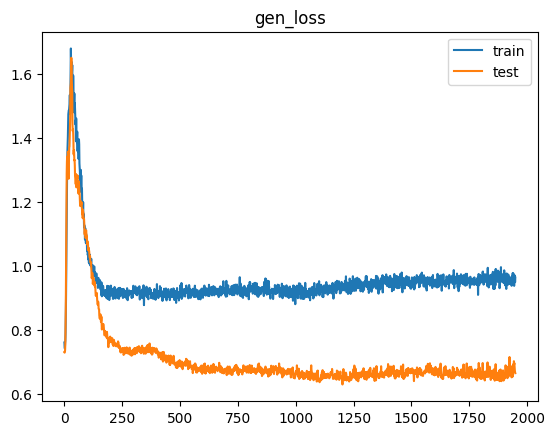

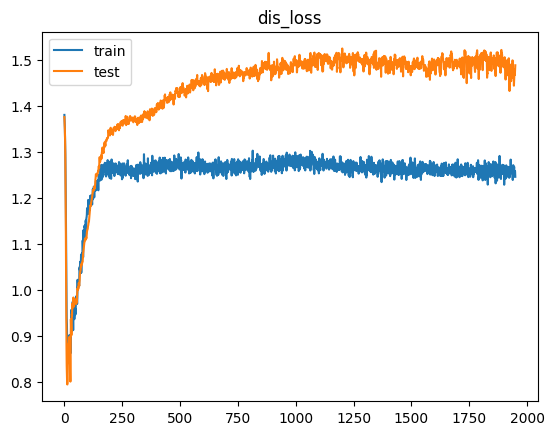

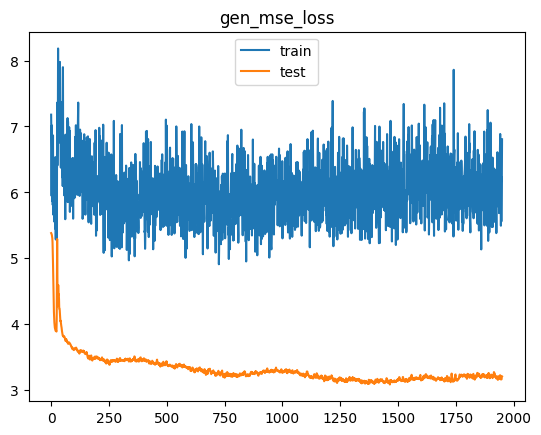

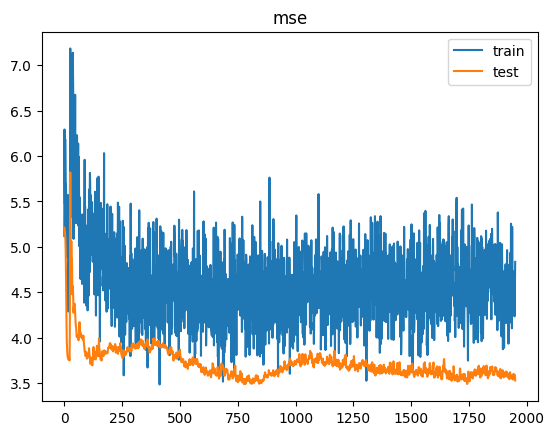

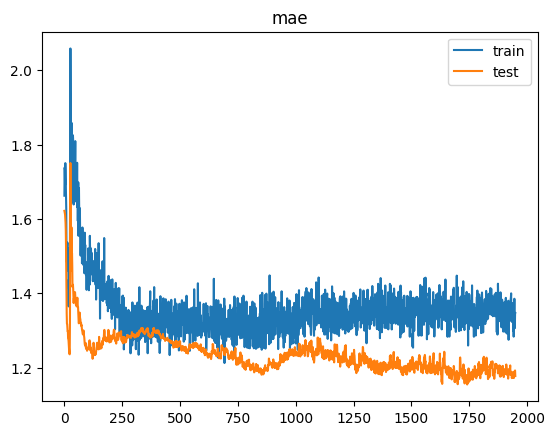

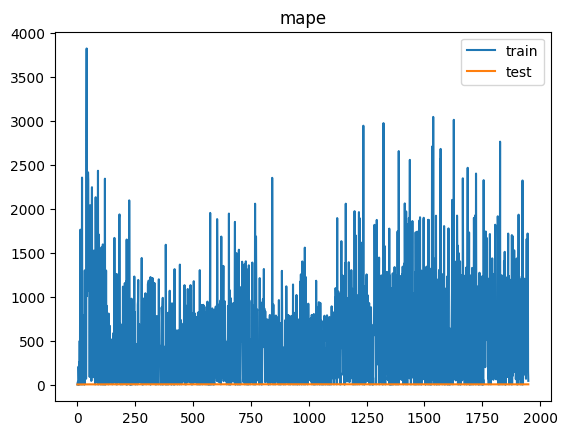

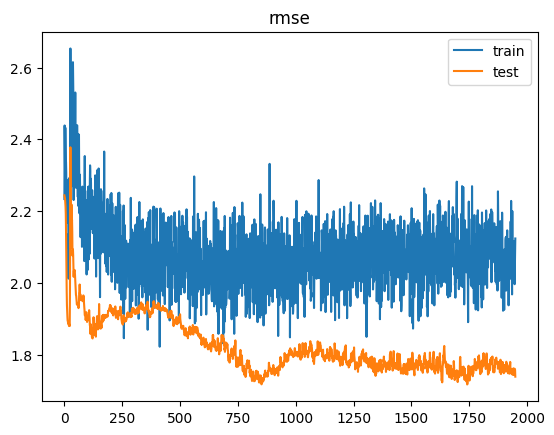

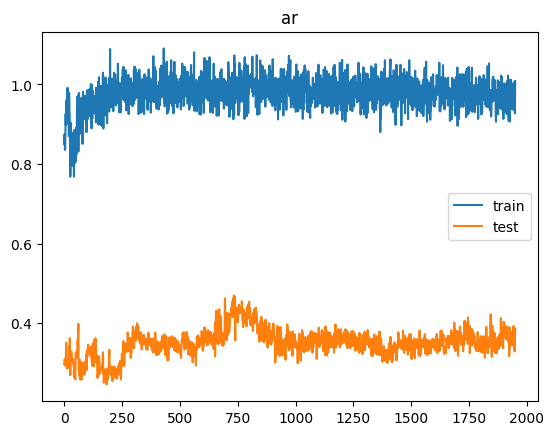

2/2 [==============================] - 0s 3ms/step


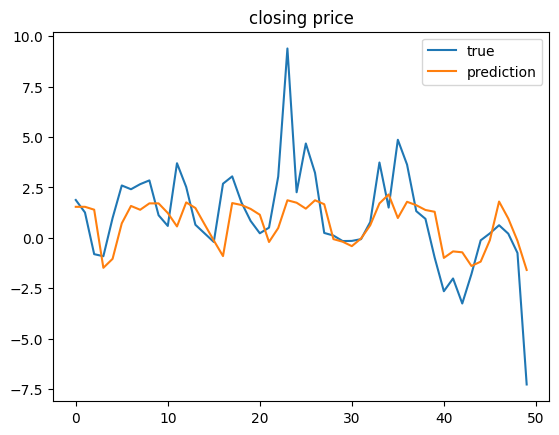

[MSE Baseline] train: 3.973004848913219  test: 3.634052838095099
Delta time with epochs = 1950: 0:17:11.867095


In [22]:
for epochs in [1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("gru_ffnn_epochs_{0}.h5".format(epochs))